# Acknowledgement

Các tình huống, định danh và dữ liệu dưới đây điều được giả định theo kinh nghiệm của người viết không mục đích chỉ định bất cứ cá nhân hay tổ chức nào. Bài toán và dữ liệu được đảm bảo tạo ra để phục vụ mục đích học tập. Không có bất kỳ sao chép dữ liệu trái phép nào.

# Bản quyền
Vui lòng không chia sẻ hay sao chép bất kỳ thông tin, nội dung hay dữ liệu của bài viết này và dùng cho mục đích thương mại khi chưa có sự đồng ý của tác giả. Tất cả dữ liệu, nội dung, thông tin chỉ được phép mục đích học tập và được sự đồng ý từ tác giả. Vui lòng liên hệ hthquan28@gmail.com nếu có nhu cầu hợp tác. Nếu bạn thấy có sự sao chép trái phép dữ liệu này ở nơi khác, vui lòng cho mình thông tin để đảm bảo quyền lợi của bạn và người mua khóa học này.

Đọc thêm: [Acknowledgement](https://docs.google.com/document/d/1gRZRnfyw3PPxLs4T7NxdiF7_Gi887IiCkygBMNUhG40/edit?usp=sharing)

# Recap

Tới đây thì bạn đã thuần thục được các kỹ năng phân tích cơ bản và hiểu được business model khi gặp bất kỳ 1 bảng dữ liệu nào

Cũng như bạn đã hiểu bạn cần phải làm gì khi nhận được 1 bảng label table data. 

Do đó bạn có thể hình dung rằng việc data preparation thường tốn nhiều thời gian hơn là modeling. 

Bên cạnh đó bạn cũng hiểu được các metrics trong Data Science ảnh hưởng tới business như thế nào.

Phần này chúng ta sẽ đi sâu vào modeling hơn ở HW3, và chúng ta sẽ căn chỉnh metrics phù hợp với yêu cầu business.

Phần này bạn sẽ không cần phân tích label, mà mình sẽ đơn giản lại cho các bạn

# A. Overview Data

Như thường lệ, các bạn sẽ chỉ làm data ở bài tập này

Mình sẽ miêu tả description data + label để các bạn hình dung rõ hơn

**Tình huống doanh nghiệp**

- Sắp tới đây (2023-02) công ty sẽ tổ chức promotion campaign, phòng ban Risk Deparment yêu cầu cần tìm ra các fraudster để đảm bảo cho các chiến dịch. 

- Leader yêu cầu bạn tạo ra predictive model có khả năng dự đoán trước tương lai. Có thể tường minh lại là bạn train model trong quá khứ và test cho tập trong khoảng thời gian mà model ko có data về nó (out-of-sample)

- Cụ thể: bạn lấy mốc 2022-10-01 trở về trước để train data và bạn dùng data sau 2022-10-01 để test. Mục đích là kiểm thử khả năng model với unseen data (or out-of-sample) & different sample distribution

> Bạn sẽ làm quen với train/test và data đi theo chiều thời gian, chúng ta sẽ dựa vào label_datetime để chia train/test

## Label

- customer_id
- label_datetime: ngày giờ được label
- fraud_label: 0 & 1 (0 ko phải fraud, 1 là fraud, vẫn là binary-classification)

## Features

Các feature mà chúng ta đã sử dụng ở HW3 và 1 số additional features

> Các bạn hãy tự làm explore feature data thông qua các kỹ năng phân tích dữ liệu ở các bài tập trước

# B. Let Solve Problem

Import thư viện cần thiết

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

In [2]:
# sklearn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


## 1. Explore Data Analysis

In [3]:
df = pd.read_csv('./data/fraud_sample.csv', index_col=0)

In [4]:
# Fix datetime col
df['label_datetime'] = pd.to_datetime(df['label_datetime'])

In [5]:
# su dung 0/1 thay vi good/bad
df['fraud_label'] = df['fraud_label'].apply(lambda x: 1 if x == 'Bad' else 0)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3333 entries, 0 to 3332
Data columns (total 62 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   customer_id                        3333 non-null   int64         
 1   label_datetime                     3333 non-null   datetime64[ns]
 2   fraud_label                        3333 non-null   int64         
 3   age                                2984 non-null   float64       
 4   gender                             2802 non-null   object        
 5   city                               3333 non-null   object        
 6   occupation                         3333 non-null   object        
 7   education                          3333 non-null   object        
 8   marital_status                     3333 non-null   object        
 9   membership_level                   3333 non-null   object        
 10  customer_points                    2330 n

Một vài column bị null rất nhiều

Chúng ta xác định các data types column bao gồm có: **bool(4), datetime64[ns], float64(15), int64(25), object(17)**

- Với bool + object sẽ là categorical features

- float + int sẽ là numerical features.

- Datetime ko sử dụng làm feature đc

### 1.1 Explore Target

Đầu tiên chúng ta sẽ explore target, tỉ lệ

- Non-fraud/fraud tương ứng với 0/1

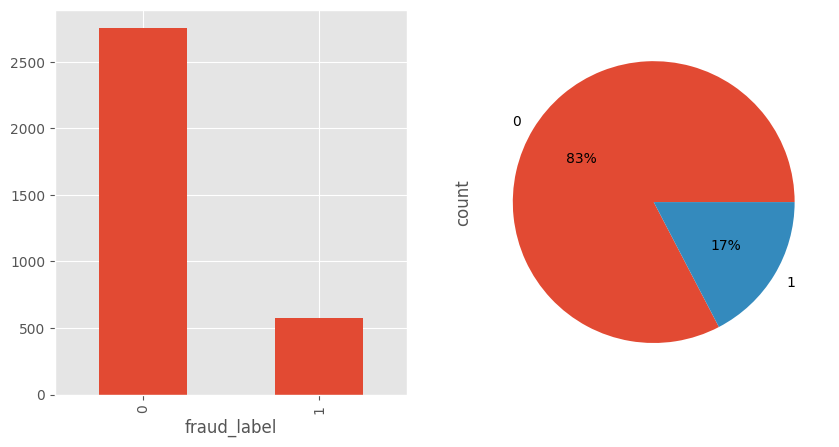

In [7]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
df['fraud_label'].value_counts().plot(kind='bar',ax=axs[0])
df['fraud_label'].value_counts().plot(kind='pie', autopct='%.0f%%', ax=axs[1])
plt.show()

### 1.2 Examine Numercial Features

Mình sẽ lấy các numerical features ra

Bạn hãy lưu ý feature most_active_hour (thời gian hoạt động active nhất trong ngày), feature này là 1 category feature chứ không phải là numerical feature nhe

In [8]:
# Get numerical feature columns
numfeat_cols = df.select_dtypes(include=np.number).columns.tolist()
numfeat_cols.remove('customer_id')
if 'fraud_label' in numfeat_cols:
    numfeat_cols.remove('fraud_label')
numfeat_cols.remove('most_active_hour')
len(numfeat_cols),numfeat_cols

(37,
 ['age',
  'customer_points',
  'total_redeemed_points',
  'discount_rate',
  'aov_last_30days',
  'membership_lifespan',
  'num_day_since_last_active',
  'num_active_last_7d',
  'num_active_last_14d',
  'num_active_last_30d',
  'num_apply_lending',
  'num_reject_lending_by_3pt',
  'total_amount_spent',
  'total_amount_spent_last_30d',
  'total_amount_spent_last_60d',
  'total_amount_spent_last_90d',
  'total_amount_spent_last_180d',
  'total_amount_spent_last_365d',
  'total_tax_amount_spent',
  'total_fee_amount_spent',
  'num_completed_txn',
  'num_canceled_txn',
  'num_reject_txn',
  'pct_reject2total_txn',
  'num_refunded_txn',
  'prob_abuse_promotion',
  'num_used_promotion',
  'prob_abnormal_activity',
  'num_select_promotion',
  'num_interest_products',
  'income_spending_ratio',
  'total_tax_amount',
  'monthly_income',
  'total_property_value',
  'monthly_bill_amount',
  'total_annual_bill_amount',
  'num_bill_overdue'])

Xem các thông tin cơ bản

In [9]:
df.describe()

customer_id                 label_datetime  fraud_label          age   
count   3333.000000                           3333  3333.000000  2984.000000  \
mean    7493.146415  2022-01-31 15:32:46.876687616     0.173417    26.322051   
min        0.000000            2021-01-02 00:00:00     0.000000    10.000000   
25%     3810.000000            2021-07-24 00:00:00     0.000000    19.000000   
50%     7455.000000            2022-02-06 00:00:00     0.000000    25.000000   
75%    11214.000000            2022-08-18 00:00:00     0.000000    31.000000   
max    14990.000000            2022-12-31 00:00:00     1.000000    79.000000   
std     4300.583757                            NaN     0.378664    10.985339   

       customer_points  total_redeemed_points  discount_rate  aov_last_30days   
count      2330.000000            3333.000000    3333.000000      3173.000000  \
mean        265.128755             131.733573       0.039202     50384.975364   
min           0.000000               0.000000       0.010000        23.713233   
25%          26.000000              10.000000       0.020000     25471.156374   
50%         112.500000              36.000000       0.030000     50300.996269   
75%         486.000000             197.000000       0.050000     75410.913849   
max        1000.000000             941.000000       0.100000     99880.751805   
std         292.294041             180.794201       0.028298     28611.125173   

       membership_lifespan  num_day_since_last_active  ...   
count          2338.000000                3333.000000  ...  \
mean            517.017109                 185.557756  ...   
min              11.000000                   1.000000  ...   
25%             324.000000                  93.000000  ...   
50%             540.000000                 186.000000  ...   
75%             727.750000                 279.000000  ...   
max             899.000000                 365.000000  ...   
std             243.334044                 106.340458  ...   

       prob_abnormal_activity  num_select_promotion  num_interest_products   
count             3206.000000           2333.000000            3333.000000  \
mean                 0.684663            553.166738              25.586859   
min                  0.010000              1.000000               0.000000   
25%                  0.540000            312.000000              13.000000   
50%                  0.740000            589.000000              26.000000   
75%                  0.890000            811.000000              38.000000   
max                  0.990000            999.000000              50.000000   
std                  0.247395            293.293958              14.492165   

       income_spending_ratio  total_tax_amount  monthly_income   
count            3333.000000      3.333000e+03    2.983000e+03  \
mean                0.493555      4.965836e+06    4.601700e+08   
min                 0.000079      1.010000e+05    1.000000e+06   
25%                 0.243990      2.472000e+06    1.020000e+08   
50%                 0.488781      4.964000e+06    4.670000e+08   
75%                 0.742791      7.413000e+06    7.795000e+08   
max                 0.999995      9.998000e+06    9.990000e+08   
std                 0.287360      2.861407e+06    3.408963e+08   

       total_property_value  monthly_bill_amount  total_annual_bill_amount   
count          3.333000e+03         1.661000e+03              3.333000e+03  \
mean           1.246295e+09         2.619049e+07              2.997997e+08   
min            1.000000e+08         1.000000e+05              3.840000e+05   
25%            9.000000e+08         1.350000e+07              1.510800e+08   
50%            1.300000e+09         2.710000e+07              3.007920e+08   
75%            1.700000e+09         3.940000e+07              4.459560e+08   
max            1.900000e+09         4.990000e+07              5.999400e+08   
std            4.871662e+08         1.457597e+07              1.721619e+08  

Nhiều feature có range dao động rất lớn ví dụ monthly_income, total_property_value, monthly_bill_amount...

Chúng ta sẽ cần standardize chúng lại nếu ko sẽ xảy ra vấn đề một số **feature bị overweighted** trong quá trình training

Chúng ta sẽ ghi nhớ điểm này để phần feature pipeline (2.2.1) sẽ nói tiếp

Chúng ta sẽ làm kiểm tra feature correlation, đính kèm label vào để xem xu hướng các feature và mối tương quan của chúng

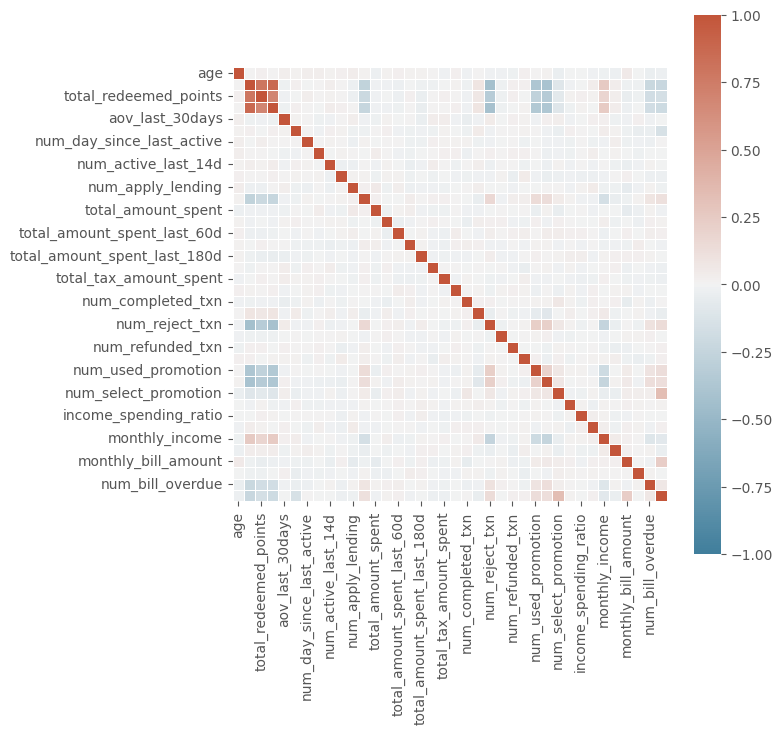

In [10]:
plt.figure(figsize=(7,7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr_maxtrix = df[numfeat_cols + ['fraud_label']].corr()
sns.heatmap(corr_maxtrix, cmap=cmap, center=0, square=True, linewidths=.5, vmin=-1, vmax=1, fmt=".2f")
plt.show()

Rõ ràng thì có 1 cụm feature có mối tương quan cao ở góc trái. Những feature có tương quan cao sẽ có khả năng đi cùng nhau về mặt tác động của nó với label (nghĩa là nếu 1 trong 3 feature có tác động mạnh vào label thì cả 3 sẽ tác động theo và ngược lại)


Còn đối với label thì hầu như ko có feature nào có tương quan với nó cả

### 1.3 Examine Category Features

Chúng ta sẽ kiểm tra category feature

In [11]:
# Get category feature columns + most_active_hour
catfeat_cols = df.select_dtypes(include=['object', bool]).columns.tolist() + ['most_active_hour']
if 'fraud_label' in numfeat_cols:
    catfeat_cols.remove('fraud_label')
len(catfeat_cols), catfeat_cols

(22,
 ['gender',
  'city',
  'occupation',
  'education',
  'marital_status',
  'membership_level',
  'has_fraud_txn',
  'has_used_jailbreak',
  'is_emulator',
  'is_blacklist',
  'signup_in_latenight',
  'top_rejected_reason',
  'top_refunded_reason',
  'top_payment_method',
  'top_payment_channel',
  'is_ordering_shipping_address_same',
  'income_stability',
  'income_source',
  'annually_income_segment',
  'top_property_type',
  'in_debt',
  'most_active_hour'])

Check unique values of each category features

In [12]:
df[catfeat_cols].nunique()

gender                                3
city                                 62
occupation                           22
education                             7
marital_status                        7
membership_level                      3
has_fraud_txn                         2
has_used_jailbreak                    2
is_emulator                           2
is_blacklist                          2
signup_in_latenight                   2
top_rejected_reason                   7
top_refunded_reason                   8
top_payment_method                    5
top_payment_channel                   5
is_ordering_shipping_address_same     2
income_stability                      4
income_source                         6
annually_income_segment               4
top_property_type                     4
in_debt                               2
most_active_hour                     24
dtype: int64

Bạn hãy để ý nếu các category feature nào có quá nhiều unique value thì sẽ gây ra 1 tình trạng gọi là **sparse matrix**

Để hiểu rõ hơn thì các category feature khi chuyển thành feature xài được thì được encode lại thành dạng One-Hot Vector. 

**One Hot Vector là gì?**

Là chuyển đổi từ 1 category columns thành k columns (với k là số lượng unique value trong column đó)

- Ví column gender có 3 giá trị [Nam, Nữ, Khác]. Khi đó one-hot-vector của gender là [0, 0, 1] với 1 sẽ là vị trí của giá trị đó

- Giả sử customer_id 1 là Nam thì giá trị one-hot-encoder của gender là [1, 0, 0] ứng với  [Nam, Nữ, Khác]

- Điều này cũng đồng nghĩa nếu giả sử cột city có 62 tỉnh thành thì sẽ là 1 vector 62 chiều. 

- Và khi nói đến city_matrix của toàn data sẽ là 1 vector toàn số 0 và rất ít số 1, gọi là **sparse matrix**

**Sparse matrix** gây ra tình trạng 

  - Chiếm bộ nhớ quá nhiều trong tính toán
  - Gây overfit cho model (đây là 1 trade-off, tuy nhiên theo mình thì dưới 100 vẫn xài được)

  
> Đối với trường hợp, sau này gender có thêm giá trị null thì One-Hot-Encoder (thư viện để chuyển đổi One-Hot-Vector của sklearn) sẽ treat null như là 1 giá trị riêng. Tương đương là vector 4 chiều [Nam, Nữ, Khác, null]

> Boolean: cũng là category feature nhé, và bạn cần cẩn thận với feature này. 

> most_active_hour tuy là dạng số nhưng về mặt data logic thì nó là category features.

**Làm sao để phân biệt category feature mà nó là *format number*:**

- Bạn hiểu rằng numberical feature có xu hướng linear, trong khi category feature có dạng non-linear transformation

  - Ví dụ linear, age có xu hướng đi từ 1 lên 65 và cao hơn

  - Ví dụ non-linear, hour trong ngày từ 1 có thể lên 23 nhưng từ 23 về 1 lại là 1 non-linear transformation

## 2. Data Pipeline

### 2.1 Train/Test selection

Đầu tiên chúng ta sẽ xem label theo tháng ra sao

- Đa phần label ở các tháng đều tương đồng, duy nhất có rất nhiều label ở tháng 2022-12

<Axes: xlabel='label_datetime'>

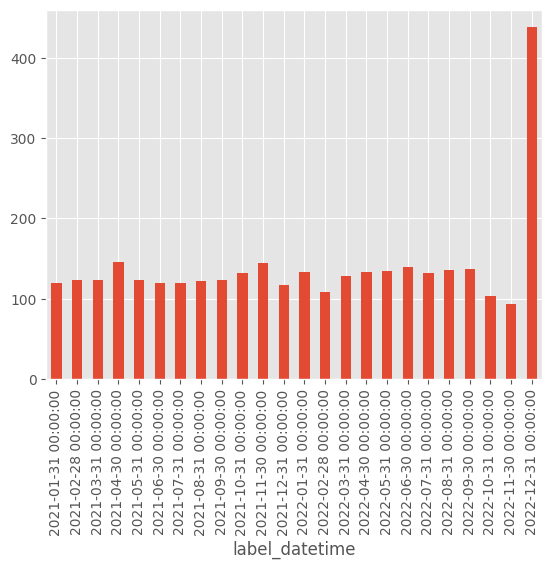

In [13]:
df.set_index('label_datetime')['customer_id'].resample('1M').nunique().plot(kind='bar')

In [14]:
# Split theo đề bài, bạn lấy mốc 2022-10 trở về trước làm train và data sau 2022-10 là test

selected_date = '2022-10-01'
train_data = df[df['label_datetime'] < selected_date]
test_data = df[df['label_datetime'] >= selected_date]

# No sample is ignored
train_data.shape, test_data.shape

((2698, 62), (635, 62))

Train and test dataset size is 81:19

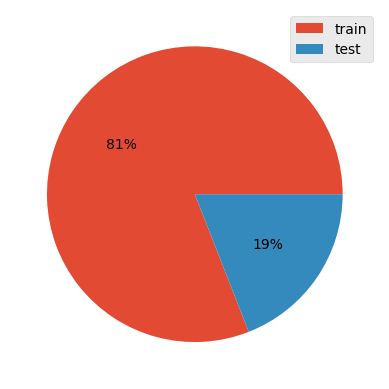

In [15]:
plt.figure()
plt.pie(x=[train_data.shape[0], test_data.shape[0]], autopct='%.0f%%')
plt.legend(['train','test'])
plt.show()

### 2.2 Feature Transformation

Chúng ta sẽ đi qua phần feature transformation

#### 2.2.1 Feature Pipeline

In [16]:
# all feat cols
feat_cols = numfeat_cols + catfeat_cols
len(feat_cols), feat_cols

(59,
 ['age',
  'customer_points',
  'total_redeemed_points',
  'discount_rate',
  'aov_last_30days',
  'membership_lifespan',
  'num_day_since_last_active',
  'num_active_last_7d',
  'num_active_last_14d',
  'num_active_last_30d',
  'num_apply_lending',
  'num_reject_lending_by_3pt',
  'total_amount_spent',
  'total_amount_spent_last_30d',
  'total_amount_spent_last_60d',
  'total_amount_spent_last_90d',
  'total_amount_spent_last_180d',
  'total_amount_spent_last_365d',
  'total_tax_amount_spent',
  'total_fee_amount_spent',
  'num_completed_txn',
  'num_canceled_txn',
  'num_reject_txn',
  'pct_reject2total_txn',
  'num_refunded_txn',
  'prob_abuse_promotion',
  'num_used_promotion',
  'prob_abnormal_activity',
  'num_select_promotion',
  'num_interest_products',
  'income_spending_ratio',
  'total_tax_amount',
  'monthly_income',
  'total_property_value',
  'monthly_bill_amount',
  'total_annual_bill_amount',
  'num_bill_overdue',
  'gender',
  'city',
  'occupation',
  'education'

Để có thể đối phó với các giá trị null và các numerical feature mà phân phối nó quá rộng, chúng ta sẽ sử dụng quick-solve

- SimpleImputer: để fill các giá trị null bằng giá trị median/mean/min/max/q25...

- StandardScaler: để standardize các numerical feature mà range nó quá rộng


Mình sử dụng Pipeline của sklearn để thiết kế cái khung trước

In [17]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

Với category features, như mình đã nói ở trên, bạn sử dụng OneHotEncoder và handle những giá trị chưa từng biết bằng cách treat những giá trị đó là vector zeros

Tham khảo thêm: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [18]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

Tạo feature pipeline với num và cat, hình vẽ minh họa ở dưới

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numfeat_cols),
        ("cat", categorical_transformer, catfeat_cols),
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'customer_points',
                                  'total_redeemed_points', 'discount_rate',
                                  'aov_last_30days', 'membership_lifespan',
                                  'num_day_since_last_active',
                                  'num_active_last_7d', 'num_active_last_14d',
                                  'num_active_last_30d', 'num_apply_lending',
                                  'n...
                                  'marital_status', 'membership_level',
                                  'has_fraud_txn', 'has_used_jailbreak',
                                  'is_emulator', 'is_blacklist',
                                  'signup_in_latenight', 'top_rejected_reason',
                                  'top_refunded_reason', 'top_payment_method',
                                  'top_payment_channel',
                                  'is_ordering_shipping_address_same',
                                  'income_stability', 'income_source',
                                  'annually_income_segment',
                                  'top_property_type', 'in_debt',
                                  'most_active_hour'])])

#### 2.2.2 X,y of train & test

In [20]:
X_train, y_train = train_data[feat_cols], train_data['fraud_label']
X_train.shape, y_train.shape

((2698, 59), (2698,))

In [21]:
X_test, y_test = test_data[feat_cols], test_data['fraud_label']
X_test.shape, y_test.shape

((635, 59), (635,))

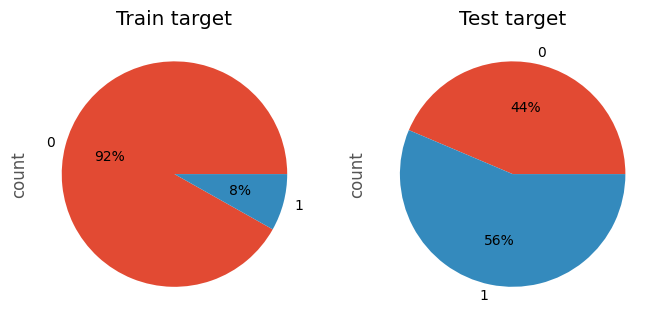

In [22]:
# Check label distribution of each dataset
fig, axs = plt.subplots(1,2, figsize=(8,5))
y_train.value_counts().sort_index().plot(kind='pie', autopct='%.0f%%',ax=axs[0], title='Train target',)
y_test.value_counts().sort_index().plot(kind='pie', autopct='%.0f%%',ax=axs[1], title='Test target')
plt.show()

Ở đây test set rất khác biệt khi lượng lớn fraud tập trung ở test, trong khi ở train, thì chỉ có 8% là fraud

Tình huống này cũng dễ gặp, khi càng gần tới mùa promotion các fraud sẽ nổi lên

#### 2.2.2 Feature Transform

In [23]:
# fit columns-transformer với feature 
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'customer_points',
                                  'total_redeemed_points', 'discount_rate',
                                  'aov_last_30days', 'membership_lifespan',
                                  'num_day_since_last_active',
                                  'num_active_last_7d', 'num_active_last_14d',
                                  'num_active_last_30d', 'num_apply_lending',
                                  'n...
                                  'marital_status', 'membership_level',
                                  'has_fraud_txn', 'has_used_jailbreak',
                                  'is_emulator', 'is_blacklist',
                                  'signup_in_latenight', 'top_rejected_reason',
                                  'top_refunded_reason', 'top_payment_method',
                                  'top_payment_channel',
                                  'is_ordering_shipping_address_same',
                                  'income_stability', 'income_source',
                                  'annually_income_segment',
                                  'top_property_type', 'in_debt',
                                  'most_active_hour'])])

Chuyển đổi data ban đầu sang thành transformed data

In [24]:
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Get new transformed feature names

In [25]:
transfeat_cols = preprocessor.get_feature_names_out()
transfeat_cols.shape, transfeat_cols

((227,),
 array(['num__age', 'num__customer_points', 'num__total_redeemed_points',
        'num__discount_rate', 'num__aov_last_30days',
        'num__membership_lifespan', 'num__num_day_since_last_active',
        'num__num_active_last_7d', 'num__num_active_last_14d',
        'num__num_active_last_30d', 'num__num_apply_lending',
        'num__num_reject_lending_by_3pt', 'num__total_amount_spent',
        'num__total_amount_spent_last_30d',
        'num__total_amount_spent_last_60d',
        'num__total_amount_spent_last_90d',
        'num__total_amount_spent_last_180d',
        'num__total_amount_spent_last_365d', 'num__total_tax_amount_spent',
        'num__total_fee_amount_spent', 'num__num_completed_txn',
        'num__num_canceled_txn', 'num__num_reject_txn',
        'num__pct_reject2total_txn', 'num__num_refunded_txn',
        'num__prob_abuse_promotion', 'num__num_used_promotion',
        'num__prob_abnormal_activity', 'num__num_select_promotion',
        'num__num_interest_prod

Các bạn sẽ thấy có tận 227 columns so với 59 columns ban đầu, lý do là OneHotEncoder đã sinh ra rất nhiều column mới

- Prefix **num__** for numerical features (which is exactly 37 cols)

- Prefix **cat__** for category features following with suffix **_{value}** of each unique value of each feature

  - suffix **_nan** indicate that OneHotEncoder treat null value as a separate value of that category feature
  
  - example: cat__gender_Khác là 1 vector one-hot thuộc gender có giá trị *Khác*

In [26]:
X_train_transformed.shape, X_test_transformed.shape

((2698, 227), (635, 227))

The number of origin features is 59 and now transformed features is 227

### 2.2 Train Pipeline

Bài vừa rồi chúng ta đã làm quen với Decision Tree và Random Forest Classifier.

Lần này chúng ta sẽ làm quen với 1 vài mô hình khác và so sánh chúng với nhau

#### K-Nearest Neighbors (KNeighbors):
**Giới thiệu:** K-Nearest Neighbors (KNeighbors) là một thuật toán dự đoán dựa trên việc xác định lớp của một điểm dữ liệu mới bằng cách so sánh với k điểm dữ liệu gần nhất trong tập huấn luyện, dựa trên khoảng cách Euclidean hoặc khoảng cách khác.

**Ưu điểm:**
- Đơn giản để triển khai và hiểu.
- Khả năng làm việc tốt với dữ liệu có chiều dữ liệu thấp.
- Khả năng mở rộng đối với số lượng lớn điểm dữ liệu.

**Nhược điểm:**
- Yêu cầu chọn kết quả tốt cho k (số lượng điểm lân cận).
- Nhạy cảm với nhiễu và dữ liệu bất thường.
- Hiệu suất yếu khi dữ liệu có chiều dữ liệu cao.

#### Logistic Regression
**Giới thiệu:** Logistic Regression là một thuật toán phân loại dựa trên hồi quy, nó ước tính xác suất của một điểm dữ liệu thuộc lớp tích cực (positive class).

**Ưu điểm:**
- Dễ dàng hiểu và giải thích.
- Phù hợp cho các bài toán có dữ liệu tương đối đơn giản và tách biệt tuyến tính.

**Nhược điểm:**
- Khả năng xử lý dữ liệu phức tạp và tách biệt phi tuyến tính kém.
- Dễ bị ảnh hưởng bởi nhiễu và dữ liệu ngoại lai.
- Có thể cần một số công việc tiền xử lý dữ liệu để phù hợp.

#### XGBoost (Extreme Gradient Boosting)
**Giới thiệu:** XGBoost là một thuật toán học máy tập trung vào cây quyết định (decision trees) được kết hợp lại thông qua phương pháp boosting. Nó có khả năng xử lý cả bài toán phân loại và hồi quy.

**Ưu điểm:**
- Hiệu suất cao và khả năng tìm ra các mô hình phức tạp.
- Xử lý tốt các dạng dữ liệu phức tạp và phi tuyến tính.
- Có khả năng xử lý dữ liệu thiếu và dữ liệu ngoại lai.

**Nhược điểm:**
- Cần cấu hình tốt để tránh overfitting.
- Đòi hỏi nhiều tài nguyên tính toán so với một số thuật toán khác.
- Dễ bị overfitting nếu không kiểm soát tốt các tham số. 

#### 2.2.1 Model selection

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

In [28]:
models = [
    ('KNeighbors', KNeighborsClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Xgboost', XGBClassifier()),
]

In [29]:
# Dict to store result of each model
results = {i[0]:{} for i in models}
results

{'KNeighbors': {},
 'Logistic Regression': {},
 'Decision Tree': {},
 'Random Forest': {},
 'Xgboost': {}}

#### 2.2.2 Model training

In [30]:
from datetime import datetime

In [31]:
for name, model in models:
    start = datetime.now()
    model.fit(X_train_transformed, y_train)
    print(name, datetime.now() - start)
    results[name]['y_train_pred'] = model.predict(X_train_transformed)
    results[name]['y_train_prob'] = model.predict_proba(X_train_transformed)
    results[name]['y_test_pred'] = model.predict(X_test_transformed)
    results[name]['y_test_prob'] = model.predict_proba(X_test_transformed)

KNeighbors 0:00:00.001360


/Users/quan/opt/miniconda3/envs/aicv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression 0:00:00.039886
Decision Tree 0:00:00.122584
Random Forest 0:00:00.689699
Xgboost 0:00:00.391810


## 3. Evaluation

Ở bài trước chúng ta đã được học Precision và Recall và hiểu tại sao Accuracy ko hữu hiệu trong bài toán imbalanced dataset

In [32]:
from sklearn import metrics

In [33]:
metric_records = {i[0]:{} for i in models}
metric_records

{'KNeighbors': {},
 'Logistic Regression': {},
 'Decision Tree': {},
 'Random Forest': {},
 'Xgboost': {}}

In [34]:
def evalute_performance(name,model):
    def evaluate_dataset(dataset):
        print(f'Evaluate {dataset} set')
        
        y_pred = results[name][f'y_{dataset}_pred']
        y_prob = results[name][f'y_{dataset}_prob']
        y_score = y_prob[:,1] # prob of positive label
        
        if dataset == 'train':
            y_true = y_train
        else:
            y_true = y_test
        
        # AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=1)
        auc_score = metrics.auc(fpr, tpr)
        print('\tAUC', auc_score)

        # ROC
        fig,axs=plt.subplots(1,3,figsize=(15,5))
        metrics.RocCurveDisplay.from_predictions(y_true, y_score, name=name, plot_chance_level=True,ax=axs[0],)
        axs[0].title.set_text('ROC binary classifibcation')

        # PRC
        metrics.PrecisionRecallDisplay.from_predictions(y_true, y_score, name=name, plot_chance_level=True, ax=axs[1],)
        axs[1].set_title("Precision-Recall curve")
        axs[1].legend(loc='best')

        # PDF
        sns.histplot(y_score,ax=axs[2])
        axs[2].set_title("Probility Distribution of Positive Label")
        plt.show()

        # classification matrix
        print('Classification Report with default threshold=0.5')
        print(metrics.classification_report(y_true, y_pred))
        p,r,f, _ = metrics.precision_recall_fscore_support(y_true, y_pred, average='binary', )
        
        metric_records[name][f'{dataset}_auc'] = auc_score
        metric_records[name][f'{dataset}_precision'] = p
        metric_records[name][f'{dataset}_recall'] = r
        metric_records[name][f'{dataset}_f1'] = f
        
    print('======================')
    print(f'Performance of {name}\n')
    evaluate_dataset('train')
    evaluate_dataset('test')
    print('\n\n')

### 3.1 KNeighbors evaluation

Performance of KNeighbors

Evaluate train set
	AUC 0.9133520434367892


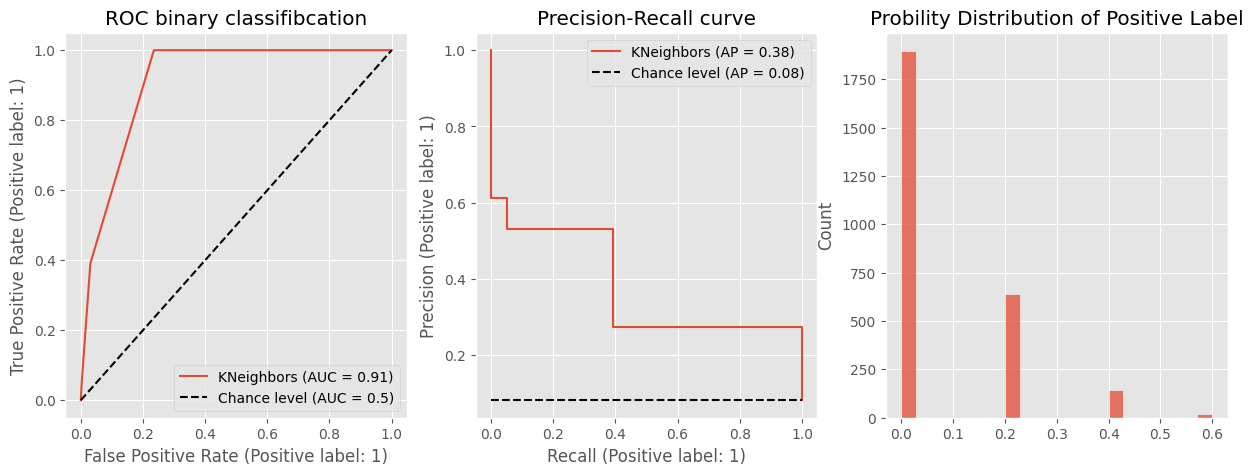

Classification Report with default threshold=0.5
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2478
           1       0.61      0.05      0.09       220

    accuracy                           0.92      2698
   macro avg       0.77      0.52      0.53      2698
weighted avg       0.90      0.92      0.89      2698

Evaluate test set
	AUC 0.6100730088941774


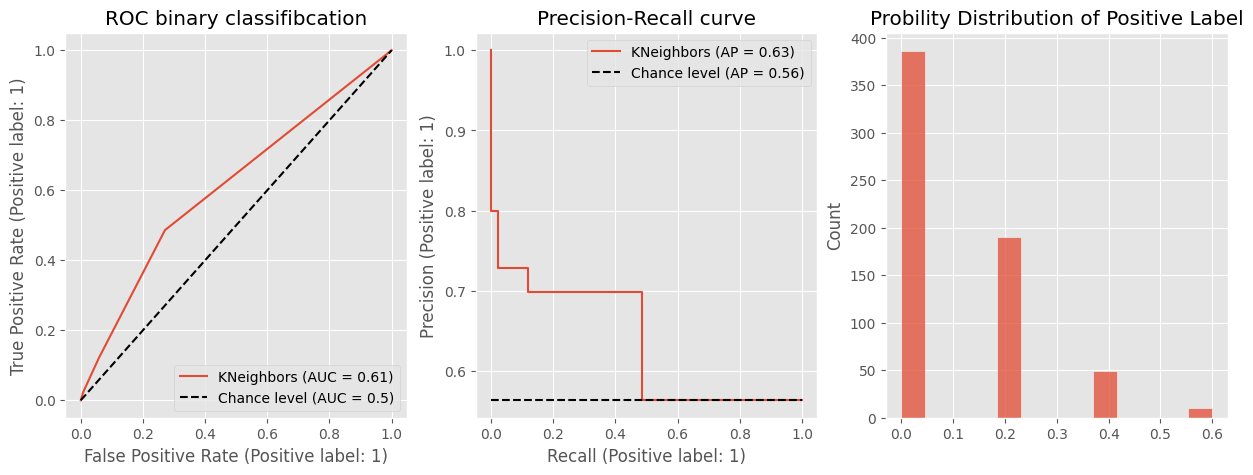

Classification Report with default threshold=0.5
              precision    recall  f1-score   support

           0       0.44      0.99      0.61       277
           1       0.80      0.02      0.04       358

    accuracy                           0.45       635
   macro avg       0.62      0.51      0.33       635
weighted avg       0.64      0.45      0.29       635






In [35]:
name, model = models[0]
evalute_performance(name, model)

### 3.2 Logistic Regression evaluation

Performance of Logistic Regression

Evaluate train set
	AUC 0.9142105070071171


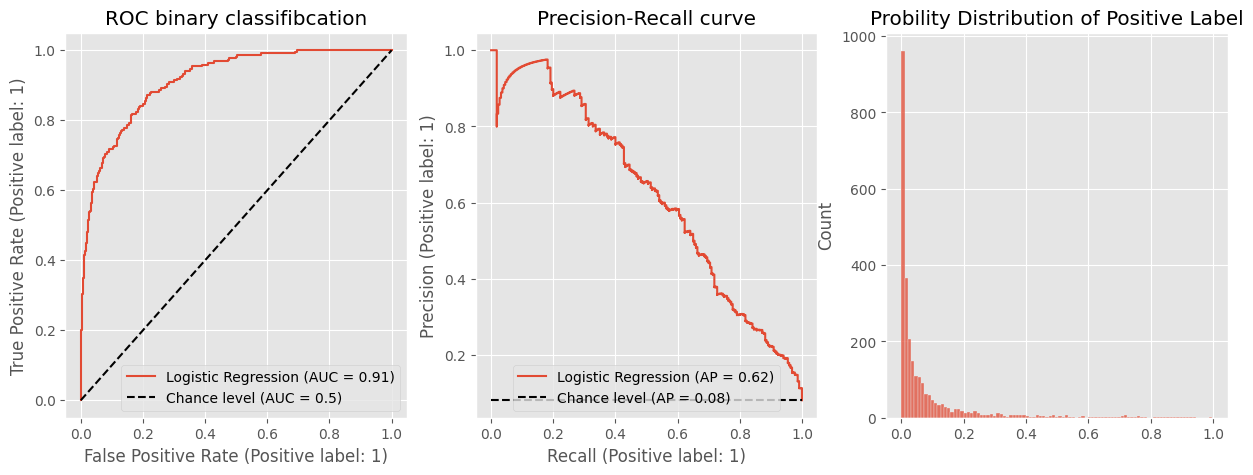

Classification Report with default threshold=0.5
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2478
           1       0.79      0.35      0.48       220

    accuracy                           0.94      2698
   macro avg       0.87      0.67      0.72      2698
weighted avg       0.93      0.94      0.93      2698

Evaluate test set
	AUC 0.8379989109170481


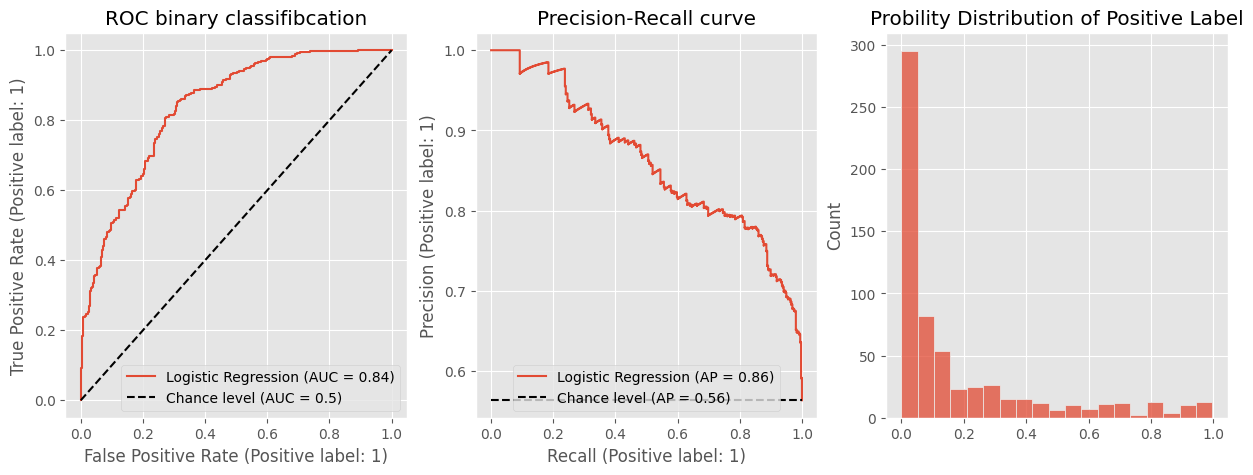

Classification Report with default threshold=0.5
              precision    recall  f1-score   support

           0       0.50      0.99      0.66       277
           1       0.98      0.23      0.37       358

    accuracy                           0.56       635
   macro avg       0.74      0.61      0.52       635
weighted avg       0.77      0.56      0.50       635






In [36]:
name, model = models[1]
evalute_performance(name, model)

### 3.3 Decision Tree evaluation

Performance of Decision Tree

Evaluate train set
	AUC 1.0


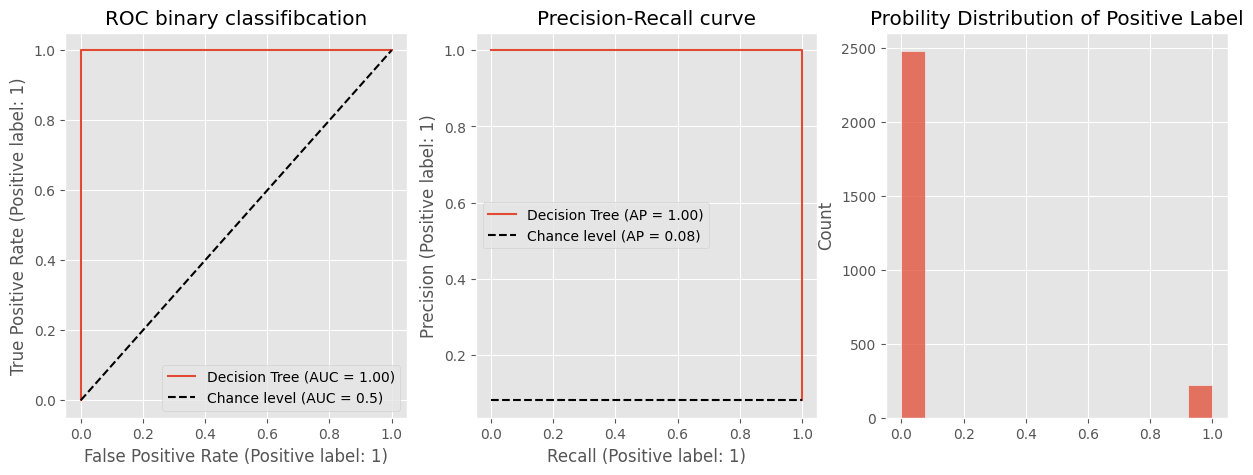

Classification Report with default threshold=0.5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2478
           1       1.00      1.00      1.00       220

    accuracy                           1.00      2698
   macro avg       1.00      1.00      1.00      2698
weighted avg       1.00      1.00      1.00      2698

Evaluate test set
	AUC 0.5934443256761389


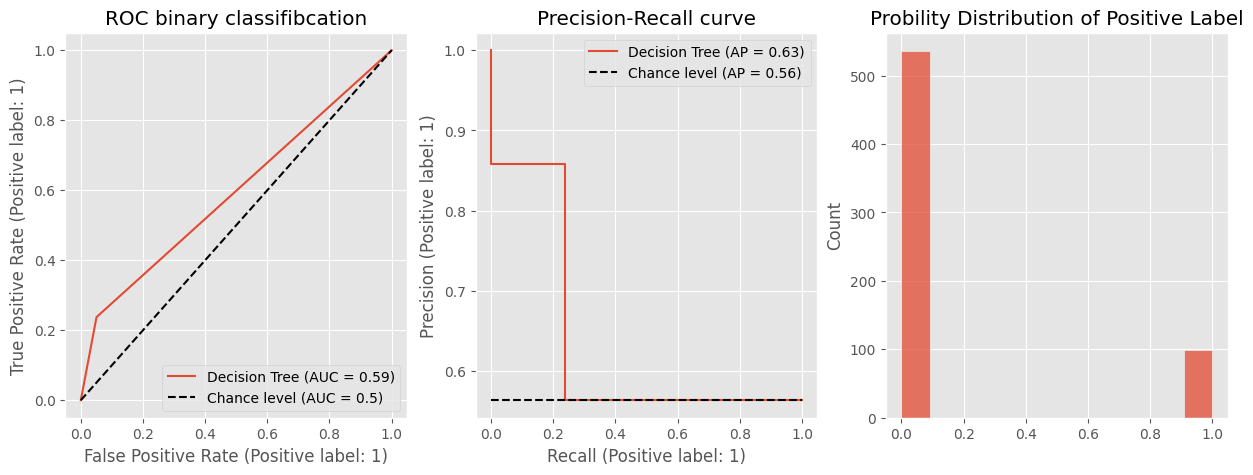

Classification Report with default threshold=0.5
              precision    recall  f1-score   support

           0       0.49      0.95      0.65       277
           1       0.86      0.24      0.37       358

    accuracy                           0.55       635
   macro avg       0.67      0.59      0.51       635
weighted avg       0.70      0.55      0.49       635






In [37]:
name, model = models[2]
evalute_performance(name, model)

### 3.4 Random Forest evaluation

Performance of Random Forest

Evaluate train set
	AUC 1.0


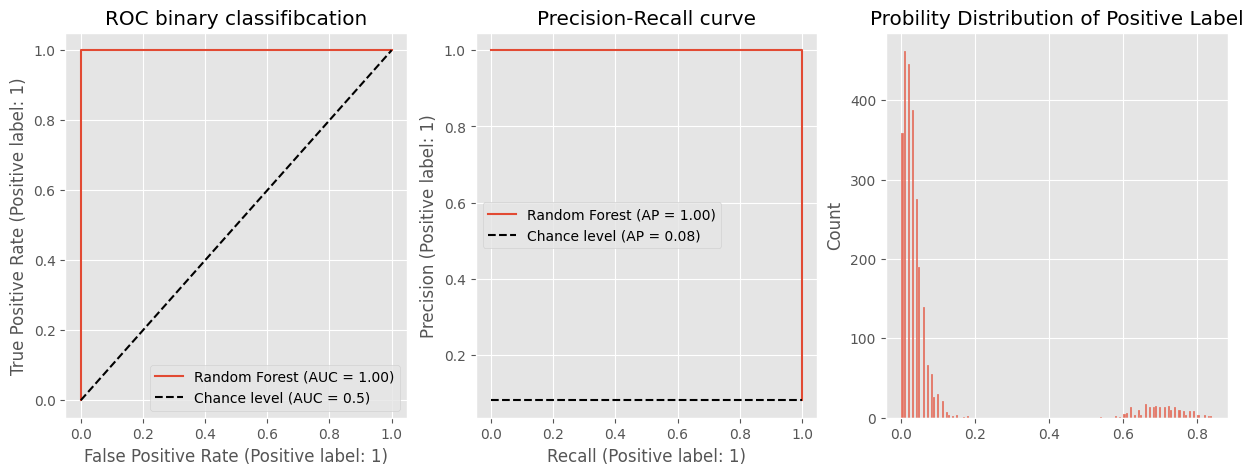

Classification Report with default threshold=0.5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2478
           1       1.00      1.00      1.00       220

    accuracy                           1.00      2698
   macro avg       1.00      1.00      1.00      2698
weighted avg       1.00      1.00      1.00      2698

Evaluate test set
	AUC 0.8284845612407479


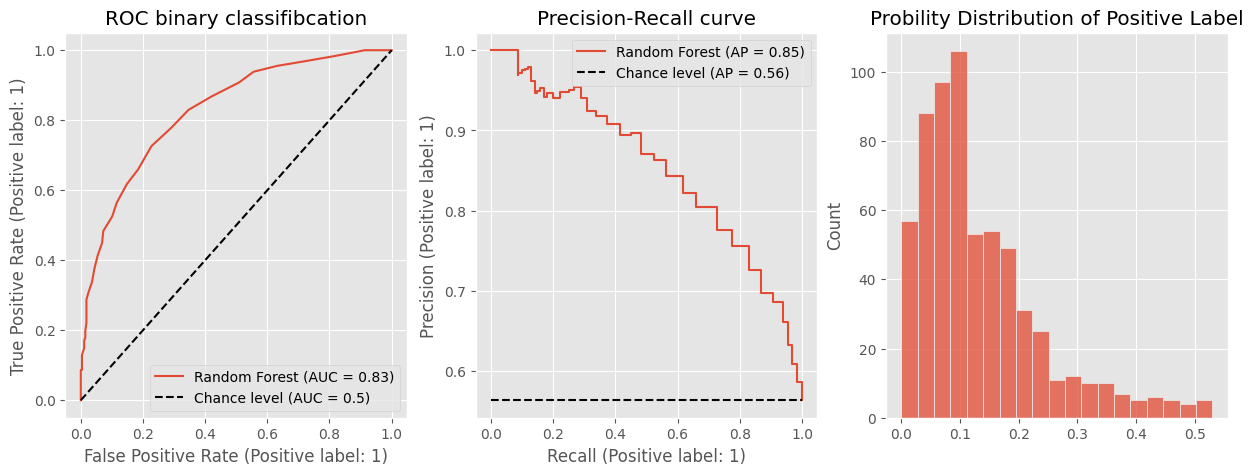

Classification Report with default threshold=0.5
              precision    recall  f1-score   support

           0       0.44      1.00      0.61       277
           1       1.00      0.01      0.03       358

    accuracy                           0.44       635
   macro avg       0.72      0.51      0.32       635
weighted avg       0.76      0.44      0.28       635






In [38]:
name, model = models[3]
evalute_performance(name, model)

### 3.5 XGboost evaluation

Performance of Xgboost

Evaluate train set
	AUC 1.0


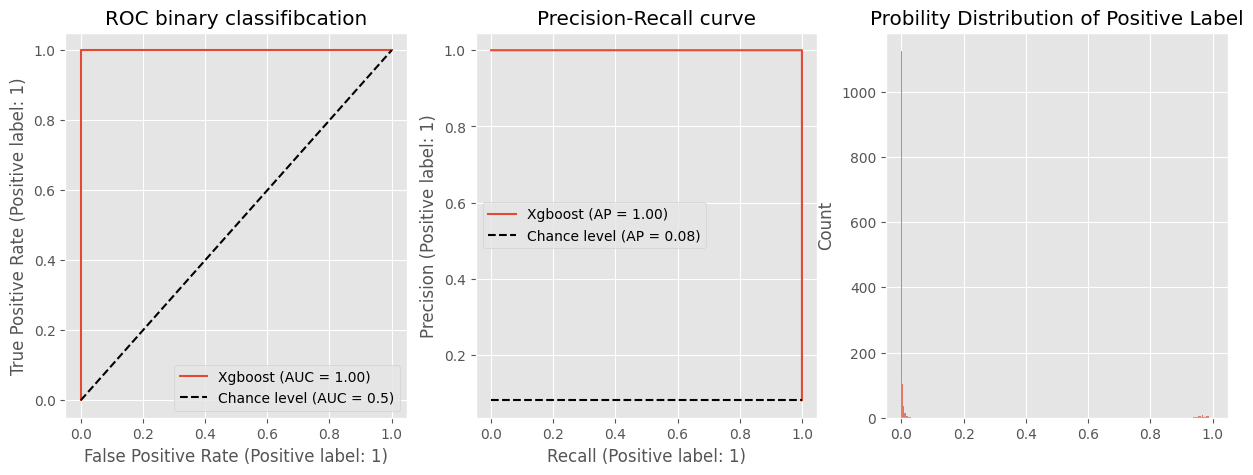

Classification Report with default threshold=0.5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2478
           1       1.00      1.00      1.00       220

    accuracy                           1.00      2698
   macro avg       1.00      1.00      1.00      2698
weighted avg       1.00      1.00      1.00      2698

Evaluate test set
	AUC 0.8284089304802049


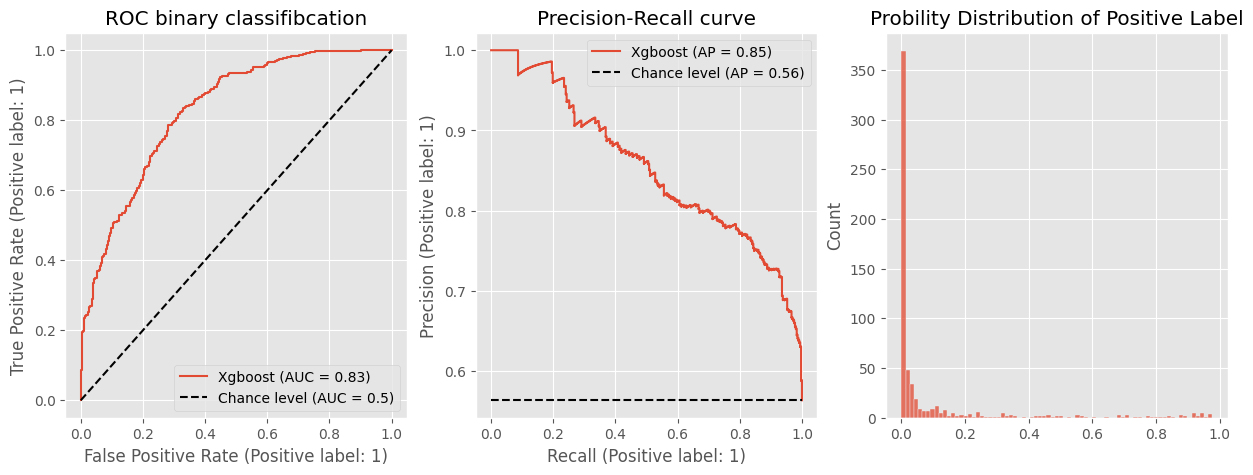

Classification Report with default threshold=0.5
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       277
           1       0.98      0.13      0.24       358

    accuracy                           0.51       635
   macro avg       0.73      0.57      0.44       635
weighted avg       0.76      0.51      0.41       635






In [39]:
name, model = models[4]
evalute_performance(name, model)

### 3.6 Compare Model Performances

In [40]:
# Metric records
record_df = pd.DataFrame(metric_records)
record_df['dataset'] = record_df.index.to_series().apply(lambda x:x.split('_')[0])
record_df['metric'] = record_df.index.to_series().apply(lambda x:x.split('_')[1])
record_df.set_index(['dataset', 'metric'])

KNeighbors  Logistic Regression  Decision Tree   
dataset metric                                                      
train   auc          0.913352             0.914211       1.000000  \
        precision    0.611111             0.791667       1.000000   
        recall       0.050000             0.345455       1.000000   
        f1           0.092437             0.481013       1.000000   
test    auc          0.610073             0.837999       0.593444   
        precision    0.800000             0.976190       0.858586   
        recall       0.022346             0.229050       0.237430   
        f1           0.043478             0.371041       0.371991   

                   Random Forest   Xgboost  
dataset metric                              
train   auc             1.000000  1.000000  
        precision       1.000000  1.000000  
        recall          1.000000  1.000000  
        f1              1.000000  1.000000  
test    auc             0.828485  0.828409  
        precision       1.000000  0.979592  
        recall          0.013966  0.134078  
        f1              0.027548  0.235872

Đối với các bài toán về Fraud Detection thì chúng ta ưu tiên chọn precision ở tập test cao. Trong trường hợp này thì Random Forest đạt được 1 kết quả rất tốt. Thông thường sau khi so sánh xong, chúng ta sẽ xác định 1 metrics và chọn model tối ưu trên metric đó. (trong trường hợp này là Random Forest)

***Nhưng để học thêm những trường hợp khác nhau, chúng ta sẽ giả sử chọn Logistic Regression là model mà chúng ta thấy tối ưu***

In [41]:
name, model = models[1]
name, model

('Logistic Regression', LogisticRegression())

## 4. Thresholding

Thresholding là kỹ thuật để căn chỉnh hiệu năng mô hình, với bài toán này, chúng ta sẽ trade-off 1 trong 2 lựa chọn sau:

### Higher Precision and Lower Recall

- Khi threshold đặt mức ngưỡng cao để đánh dấu gian lận, nó sẽ đánh dấu các giao dịch là gian lận chỉ khi nó rất chắc chắn về tính gian lận của chúng. Điều này dẫn đến một tỷ lệ cao các giao dịch được đánh dấu là gian lận đúng (true positives) trong số tất cả các giao dịch được đánh dấu là gian lận (bao gồm cả true positives và false positives), nghĩa là chính xác cao. Tuy nhiên, hệ thống có thể bỏ sót một số giao dịch gian lận (false negatives). **An toàn là trên hết**

### Higher Recall and Lower Precision

- Khi threshold đặt mức ngưỡng thấp, nó có khả năng phát hiện nhiều giao dịch gian lận, bao gồm cả những giao dịch có khả năng là gian lận nhỏ. Model có khả năng phát hiện được nhiều giao dịch gian lận, giảm nguy cơ bỏ sót giao dịch gian lận (false negatives). Tuy nhiên, do hệ thống đánh dấu các giao dịch có khả năng là gian lận nhỏ, có thể dẫn đến một số lượng giao dịch không gian lận bị đánh dấu là gian lận sai (false positives). **Thà bắt nhầm còn hơn bỏ sót**

Tuy nhiên bài toán này rất quan trọng việc nhầm lẫn KH tốt thành xấu (false positive) nên chúng ta sẽ ưu tiên giảm false positive xuống thấp nhất có thể hay là chọn High Precision và Lower Recall xuống

In [42]:
y_pred = results[name]['y_test_pred']
y_prob = results[name]['y_test_prob']
y_score = y_prob[:,1]

In [43]:
def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.style.use('ggplot')
    plt.plot(thresholds, precisions[:-1], "b", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g", label="Recall")
    plt.axvline(x = 0.5, color = 'r', label = 'default-threshold',linestyle=':')
    plt.axvline(x = 0.01, color = 'orange', label = '0.01 threshold',linestyle='-.')
    plt.axvline(x = 0.4, color = 'orange', label = '0.4 threshold',linestyle='-.')
    plt.xlabel("Threshold")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid( which="both", axis="both", color='gray', linestyle='-', linewidth=1)
    plt.show()

In [44]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_score)

Plot sự biến đổi giữa precision và recall theo threshold, hình dưới miêu tả

- Nếu ta tăng threshold thì precision cũng tăng theo và recall giảm và ngược lại

- Mặc định các mô hình chọn threshold là 0.5

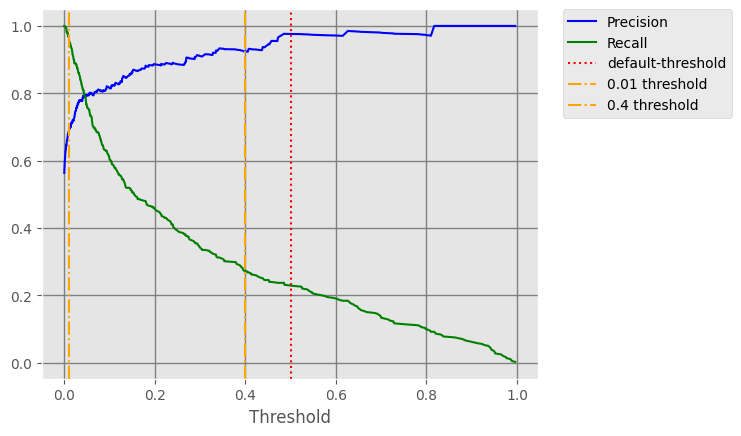

In [45]:
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)
plt.show()

Giờ chúng ta sẽ xem xét 2 tình huống threshold là 0.01 và threshold là 0.8

In [46]:
threshold_df = pd.DataFrame({
    'thresholds': [0] + thresholds.tolist(),
    'precisions': precisions, 
    'recalls': recalls, 
})
threshold_df

thresholds  precisions   recalls
0      0.000000    0.563780  1.000000
1      0.000056    0.564669  1.000000
2      0.000077    0.565561  1.000000
3      0.000117    0.566456  1.000000
4      0.000121    0.567353  1.000000
..          ...         ...       ...
631    0.976793    1.000000  0.011173
632    0.985437    1.000000  0.008380
633    0.987389    1.000000  0.005587
634    0.988482    1.000000  0.002793
635    0.995960    1.000000  0.000000

[636 rows x 3 columns]

Bảng dưới đây là kết quả của 2 threshold

In [47]:
thresh_1 = 0.01
thresh_2 = 0.4

idx_threshold_1 = (threshold_df['thresholds']<=thresh_1).sum()
idx_threshold_40 = (threshold_df['thresholds']<=thresh_2).sum()
threshold_df.iloc[[idx_threshold_1,idx_threshold_40],:].reset_index(drop=True)

thresholds  precisions   recalls
0    0.010006    0.685149  0.966480
1    0.404355    0.923077  0.268156

**Hãy xem so sánh kết quả của 2 threshold**

In [48]:
y_pred_thres_1pct = (y_prob[:,1] >= thresh_1).astype(int)
y_pred_thres_40pct = (y_prob[:,1] >= thresh_2).astype(int)

In [49]:
# calculate precision/recall/f1/accuracy with selected threshold
p1 = metrics.precision_score(y_test, y_pred_thres_1pct)
r1 = metrics.recall_score(y_test, y_pred_thres_1pct)
a1 = metrics.accuracy_score(y_test, y_pred_thres_1pct)
f1_1 = metrics.f1_score(y_test, y_pred_thres_1pct)

p2 = metrics.precision_score(y_test, y_pred_thres_40pct)
r2 = metrics.recall_score(y_test, y_pred_thres_40pct)
a2 = metrics.accuracy_score(y_test, y_pred_thres_40pct)
f1_2 = metrics.f1_score(y_test, y_pred_thres_40pct)

In [50]:
cm1 = metrics.confusion_matrix(y_test, y_pred_thres_1pct, labels=[0,1])
cm2 = metrics.confusion_matrix(y_test, y_pred_thres_40pct, labels=[0,1])

In [51]:
tn1, fp1, fn1, tp1 = cm1.ravel()
tn2, fp2, fn2, tp2 = cm2.ravel()

Dưới đây là 1 confusion matrix

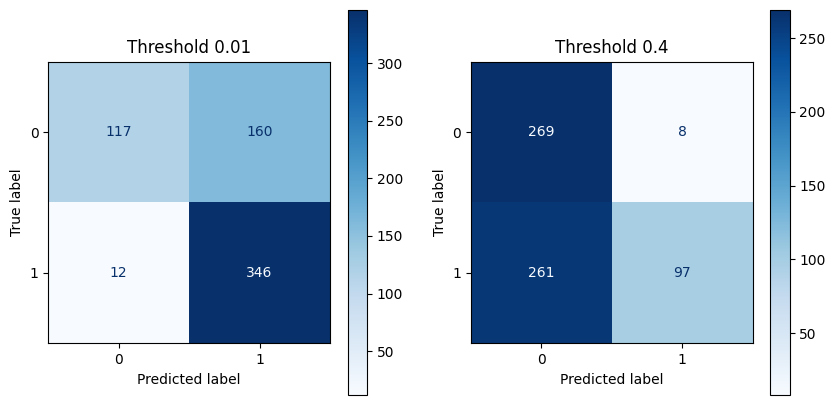

In [52]:
plt.style.use('default')
fig, axs = plt.subplots(1,2, figsize=(10, 5))

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thres_1pct,cmap=plt.cm.Blues,ax=axs[0])
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thres_40pct,cmap=plt.cm.Blues,ax=axs[1])
axs[0].set_title('Threshold 0.01')
axs[1].set_title('Threshold 0.4')
plt.show()

In [53]:
benchmark_df = pd.DataFrame({
    'metric': ['tp', 'fp','tp+fp','precision','recall', 'tp', 'fp','tp+fp','precision','recall'],
    'threshold': [0.01,0.01,0.01,0.01,0.01,0.4,0.4,0.4,0.4,0.4],
    'value': [tp1,fp1,tp1+fp1,p1,r1,tp2,fp2,tp2+fp2,p2,r2]
}).pivot_table(index='threshold', columns='metric',values='value')
benchmark_df['tp'] = benchmark_df['tp'].astype(int)
benchmark_df['fp'] = benchmark_df['fp'].astype(int)
benchmark_df['tp+fp'] = benchmark_df['tp+fp'].astype(int)
benchmark_df[['tp', 'fp', 'tp+fp', 'precision','recall']]

metric      tp   fp  tp+fp  precision   recall
threshold                                     
0.01       346  160    506   0.683794  0.96648
0.40        97    8    105   0.923810  0.27095

Bạn có thể thấy trade-off giữa precision và recall khi chọn threshold, và đây là tiền đề để làm các bài toán scoring sâu hơn.

In [54]:
name, model = models[2]
name, model

('Decision Tree', DecisionTreeClassifier())

Việc ưu tiên giảm False Positive là quan trọng trong bài toán này tương đương với việc tăng threshold cao hơn (nhưng cũng đồng thời giảm Recall xuống)

Lúc này chúng ta sẽ giải thích cho business stake-holder cặn kẽ và hiểu xem họ mong muốn gì.

Tiếp theo chúng ta sẽ đi vào phân tích 1 số feature importance 

Chúng ta sẽ quay trở lại với Random Forest model vì nó performance tốt nhất

## 5. Deep analysis

In [55]:
plt.style.use('ggplot')

In [56]:
name, model = models[3]
name, model

('Random Forest', RandomForestClassifier())

### 5.1 Feature Importance

Get feature importance from the Random Forest Model

Feature Importances of model Random Forest


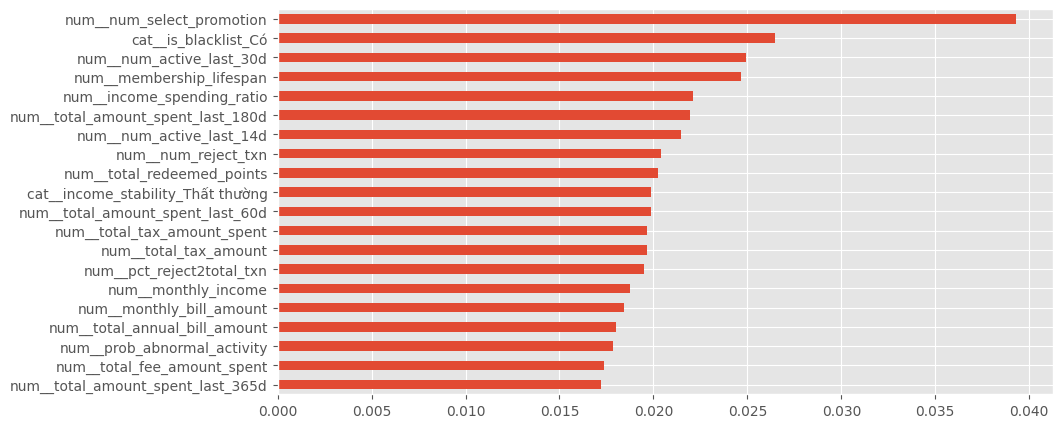

In [57]:
feat_imp_dict = {}

print(f'Feature Importances of model {name}')
featimp_series = pd.Series(model.feature_importances_,index = transfeat_cols)
featimp_series.nlargest(20)[::-1].plot(kind='barh',figsize=(10,5))
plt.show()
feat_imp_dict[name] = featimp_series

Let deep dive into selected features of Random Forest based on feature importance

### 5.2. Analyze Top 20 Feature Importance 

In [58]:
top_transfeats = feat_imp_dict[name].sort_values(ascending=False)[:20]
top_transfeats

num__num_select_promotion            0.039280
cat__is_blacklist_Có                 0.026462
num__num_active_last_30d             0.024928
num__membership_lifespan             0.024636
num__income_spending_ratio           0.022112
num__total_amount_spent_last_180d    0.021972
num__num_active_last_14d             0.021480
num__num_reject_txn                  0.020422
num__total_redeemed_points           0.020242
cat__income_stability_Thất thường    0.019850
num__total_amount_spent_last_60d     0.019849
num__total_tax_amount_spent          0.019685
num__total_tax_amount                0.019670
num__pct_reject2total_txn            0.019518
num__monthly_income                  0.018759
num__monthly_bill_amount             0.018433
num__total_annual_bill_amount        0.018022
num__prob_abnormal_activity          0.017831
num__total_fee_amount_spent          0.017382
num__total_amount_spent_last_365d    0.017212
dtype: float64

Trong top các feature của Random Forest, có 1 số feature category đã bị transform nên bạn cần inverse_transform nó lại để mình có thể phân tích từ original feature

In [59]:
def get_origin_feature_name(x):
    if x.startswith('cat__'):
        res = x.replace('cat__','')
        suffix_idx = res.rfind('_')
        origin_feat_name = res[:suffix_idx]
    else:
        res = x.replace('num__','')
        origin_feat_name = res
    return origin_feat_name

In [60]:
top_originfeats = top_transfeats.index.to_series().apply(lambda x: get_origin_feature_name(x)).tolist()
topfeat_df = top_transfeats.to_frame().reset_index()
topfeat_df['origin_name'] = top_originfeats
topfeat_df = topfeat_df.rename(columns={0:'score'})
topfeat_df['kind'] = topfeat_df['index'].apply(lambda x: 'cat' if x.startswith('cat') else 'num')
topfeat_df

index     score                   origin_name   
0           num__num_select_promotion  0.039280          num_select_promotion  \
1                cat__is_blacklist_Có  0.026462                  is_blacklist   
2            num__num_active_last_30d  0.024928           num_active_last_30d   
3            num__membership_lifespan  0.024636           membership_lifespan   
4          num__income_spending_ratio  0.022112         income_spending_ratio   
5   num__total_amount_spent_last_180d  0.021972  total_amount_spent_last_180d   
6            num__num_active_last_14d  0.021480           num_active_last_14d   
7                 num__num_reject_txn  0.020422                num_reject_txn   
8          num__total_redeemed_points  0.020242         total_redeemed_points   
9   cat__income_stability_Thất thường  0.019850              income_stability   
10   num__total_amount_spent_last_60d  0.019849   total_amount_spent_last_60d   
11        num__total_tax_amount_spent  0.019685        total_tax_amount_spent   
12              num__total_tax_amount  0.019670              total_tax_amount   
13          num__pct_reject2total_txn  0.019518          pct_reject2total_txn   
14                num__monthly_income  0.018759                monthly_income   
15           num__monthly_bill_amount  0.018433           monthly_bill_amount   
16      num__total_annual_bill_amount  0.018022      total_annual_bill_amount   
17        num__prob_abnormal_activity  0.017831        prob_abnormal_activity   
18        num__total_fee_amount_spent  0.017382        total_fee_amount_spent   
19  num__total_amount_spent_last_365d  0.017212  total_amount_spent_last_365d   

   kind  
0   num  
1   cat  
2   num  
3   num  
4   num  
5   num  
6   num  
7   num  
8   num  
9   cat  
10  num  
11  num  
12  num  
13  num  
14  num  
15  num  
16  num  
17  num  
18  num  
19  num

Có 19 numerical feature và 1 categorical feature quan trọng

In [61]:
topfeat_df[['origin_name', 'kind']].drop_duplicates()['kind'].value_counts()

kind
num    18
cat     2
Name: count, dtype: int64

In [62]:
# the order of feature importance is kept as same order
aly_col = topfeat_df['origin_name'].unique().tolist()

In [63]:
tmp = topfeat_df[['origin_name', 'kind']].drop_duplicates()
aly_col_kind_map = dict(zip(tmp['origin_name'].tolist(), tmp['kind'].tolist()))

Data Frame chứa thông tin của các feature importance

In [64]:
aly_train, aly_test = train_data[aly_col + ['fraud_label']], test_data[aly_col + ['fraud_label']]
aly_train

num_select_promotion is_blacklist  num_active_last_30d   
0                      NaN        Không                  768  \
1                      NaN        Không                  221   
4                     90.0        Không                  789   
5                    668.0        Không                   72   
6                    771.0        Không                  336   
...                    ...          ...                  ...   
3328                   NaN        Không                  590   
3329                   NaN        Không                  808   
3330                   NaN        Không                  876   
3331                   NaN        Không                  118   
3332                 263.0        Không                  856   

      membership_lifespan  income_spending_ratio   
0                   576.0               0.957445  \
1                   277.0               0.652132   
4                   891.0               0.306142   
5                   888.0               0.614712   
6                   863.0               0.196916   
...                   ...                    ...   
3328                780.0               0.134307   
3329                507.0               0.978269   
3330                811.0               0.036441   
3331                  NaN               0.277808   
3332                  NaN               0.430195   

      total_amount_spent_last_180d  num_active_last_14d  num_reject_txn   
0                        834777000                  441              17  \
1                        938719000                  515              53   
4                        265511000                  588              41   
5                        901000000                  247              22   
6                        397339000                  517              47   
...                            ...                  ...             ...   
3328                     314751000                   13               4   
3329                     201824000                  143              64   
3330                     392721000                  177              28   
3331                     106340000                  371              64   
3332                     843047000                  121              37   

      total_redeemed_points income_stability  ...  total_tax_amount_spent   
0                        94      Thất thường  ...                52386100  \
1                        61      Rất ổn định  ...                24954100   
4                       153      Rất ổn định  ...                99908600   
5                       161      Rất ổn định  ...                31632900   
6                       106           Tạm ổn  ...                34269700   
...                     ...              ...  ...                     ...   
3328                      3          Ổn định  ...                64850400   
3329                     31          Ổn định  ...                31064800   
3330                     25          Ổn định  ...                91503500   
3331                    298           Tạm ổn  ...                40179200   
3332                     63          Ổn định  ...                61728700   

      total_tax_amount  pct_reject2total_txn  monthly_income   
0              5410000              0.698079      16000000.0  \
1              9656000              0.736992     181000000.0   
4              1146000              0.183559             NaN   
5              4419000              0.657768      50000000.0   
6              6057000              0.139249     473000000.0   
...                ...                   ...             ...   
3328           8159000              0.898378     797000000.0   
3329           3445000              0.761456             NaN   
3330           6292000              0.281212       2000000.0   
3331           8154000              0.348357       1000000.0   
3332           6835000              0.559114     616000000.0   

      monthly_bil

Plot some distribution analysis related to top feature importance

#### 5.2.1 Top Categorical features

Bây giờ chúng ta sẽ plot categorical feature đi cùng với phân phối label của cả train và test set

In [65]:
aly_cat_col = [i for i in aly_col if aly_col_kind_map[i] == 'cat']
aly_cat_col

['is_blacklist', 'income_stability']

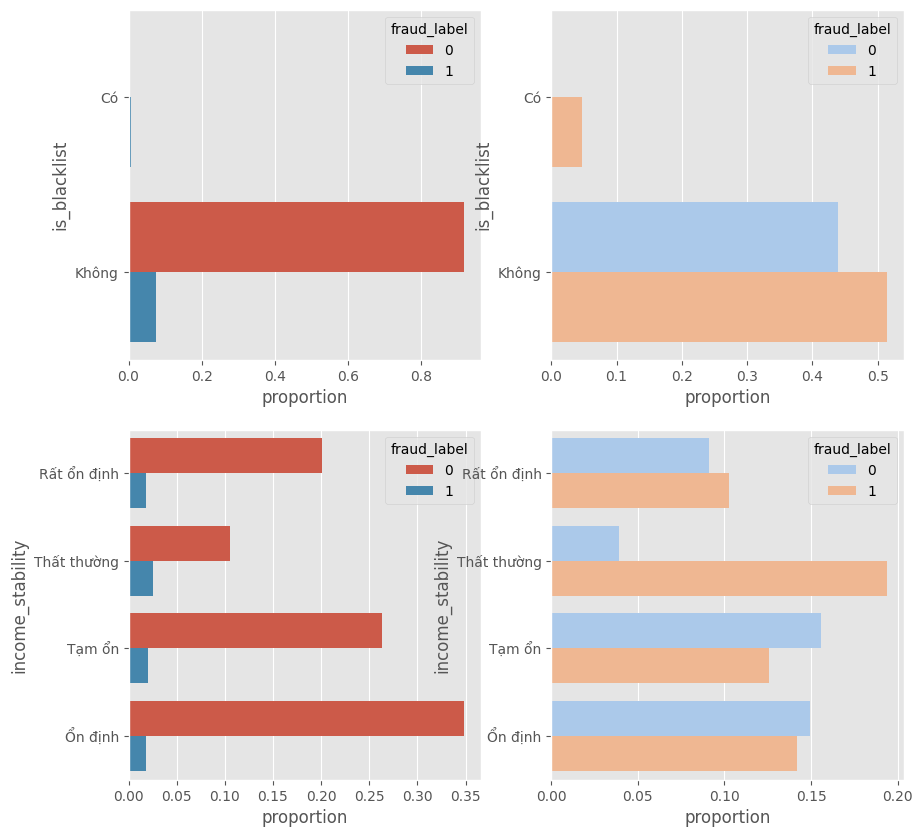

In [66]:
if len(aly_cat_col) > 0:
    fig, axs = plt.subplots(len(aly_cat_col),2, figsize=(10, len(aly_cat_col) * 5))
    for idx, c in enumerate(aly_cat_col):
        if len(aly_cat_col) == 1:
            ax_left, ax_right = axs[0], axs[1]
        else:
            ax_left, ax_right = axs[idx][0], axs[idx][1]
        # Train
        tmp_train = aly_train[[c,'fraud_label']].value_counts(normalize=True).to_frame().reset_index().sort_values(c)
        sns.barplot(data=tmp_train, y=c,hue='fraud_label', x='proportion',ax=ax_left)
        # Test
        tmp_test = aly_test[[c,'fraud_label']].value_counts(normalize=True).to_frame().reset_index().sort_values(c)
        sns.barplot(data=tmp_test, y=c,hue='fraud_label', x='proportion',ax=ax_right, palette='pastel')
    plt.show()

Left figures are train, right figures are test

As above illustration, some comments:

- Chúng ta thấy rằng tỉ lệ fraud của giá trị Không blacklist của train rất khác với với test

Nó cũng ẩn ý rằng tại sao RandomForest fit rất tốt với train mà lại ko đúng hoàn toàn bên test

#### 5.2.2 Top Numerical features

In [67]:
k = 5
aly_num_col = [i for i in aly_col if aly_col_kind_map[i] =='num'][:k]
aly_num_col

['num_select_promotion',
 'num_active_last_30d',
 'membership_lifespan',
 'income_spending_ratio',
 'total_amount_spent_last_180d']

Below is the top feature distribution with its label, left is train set and right is test set

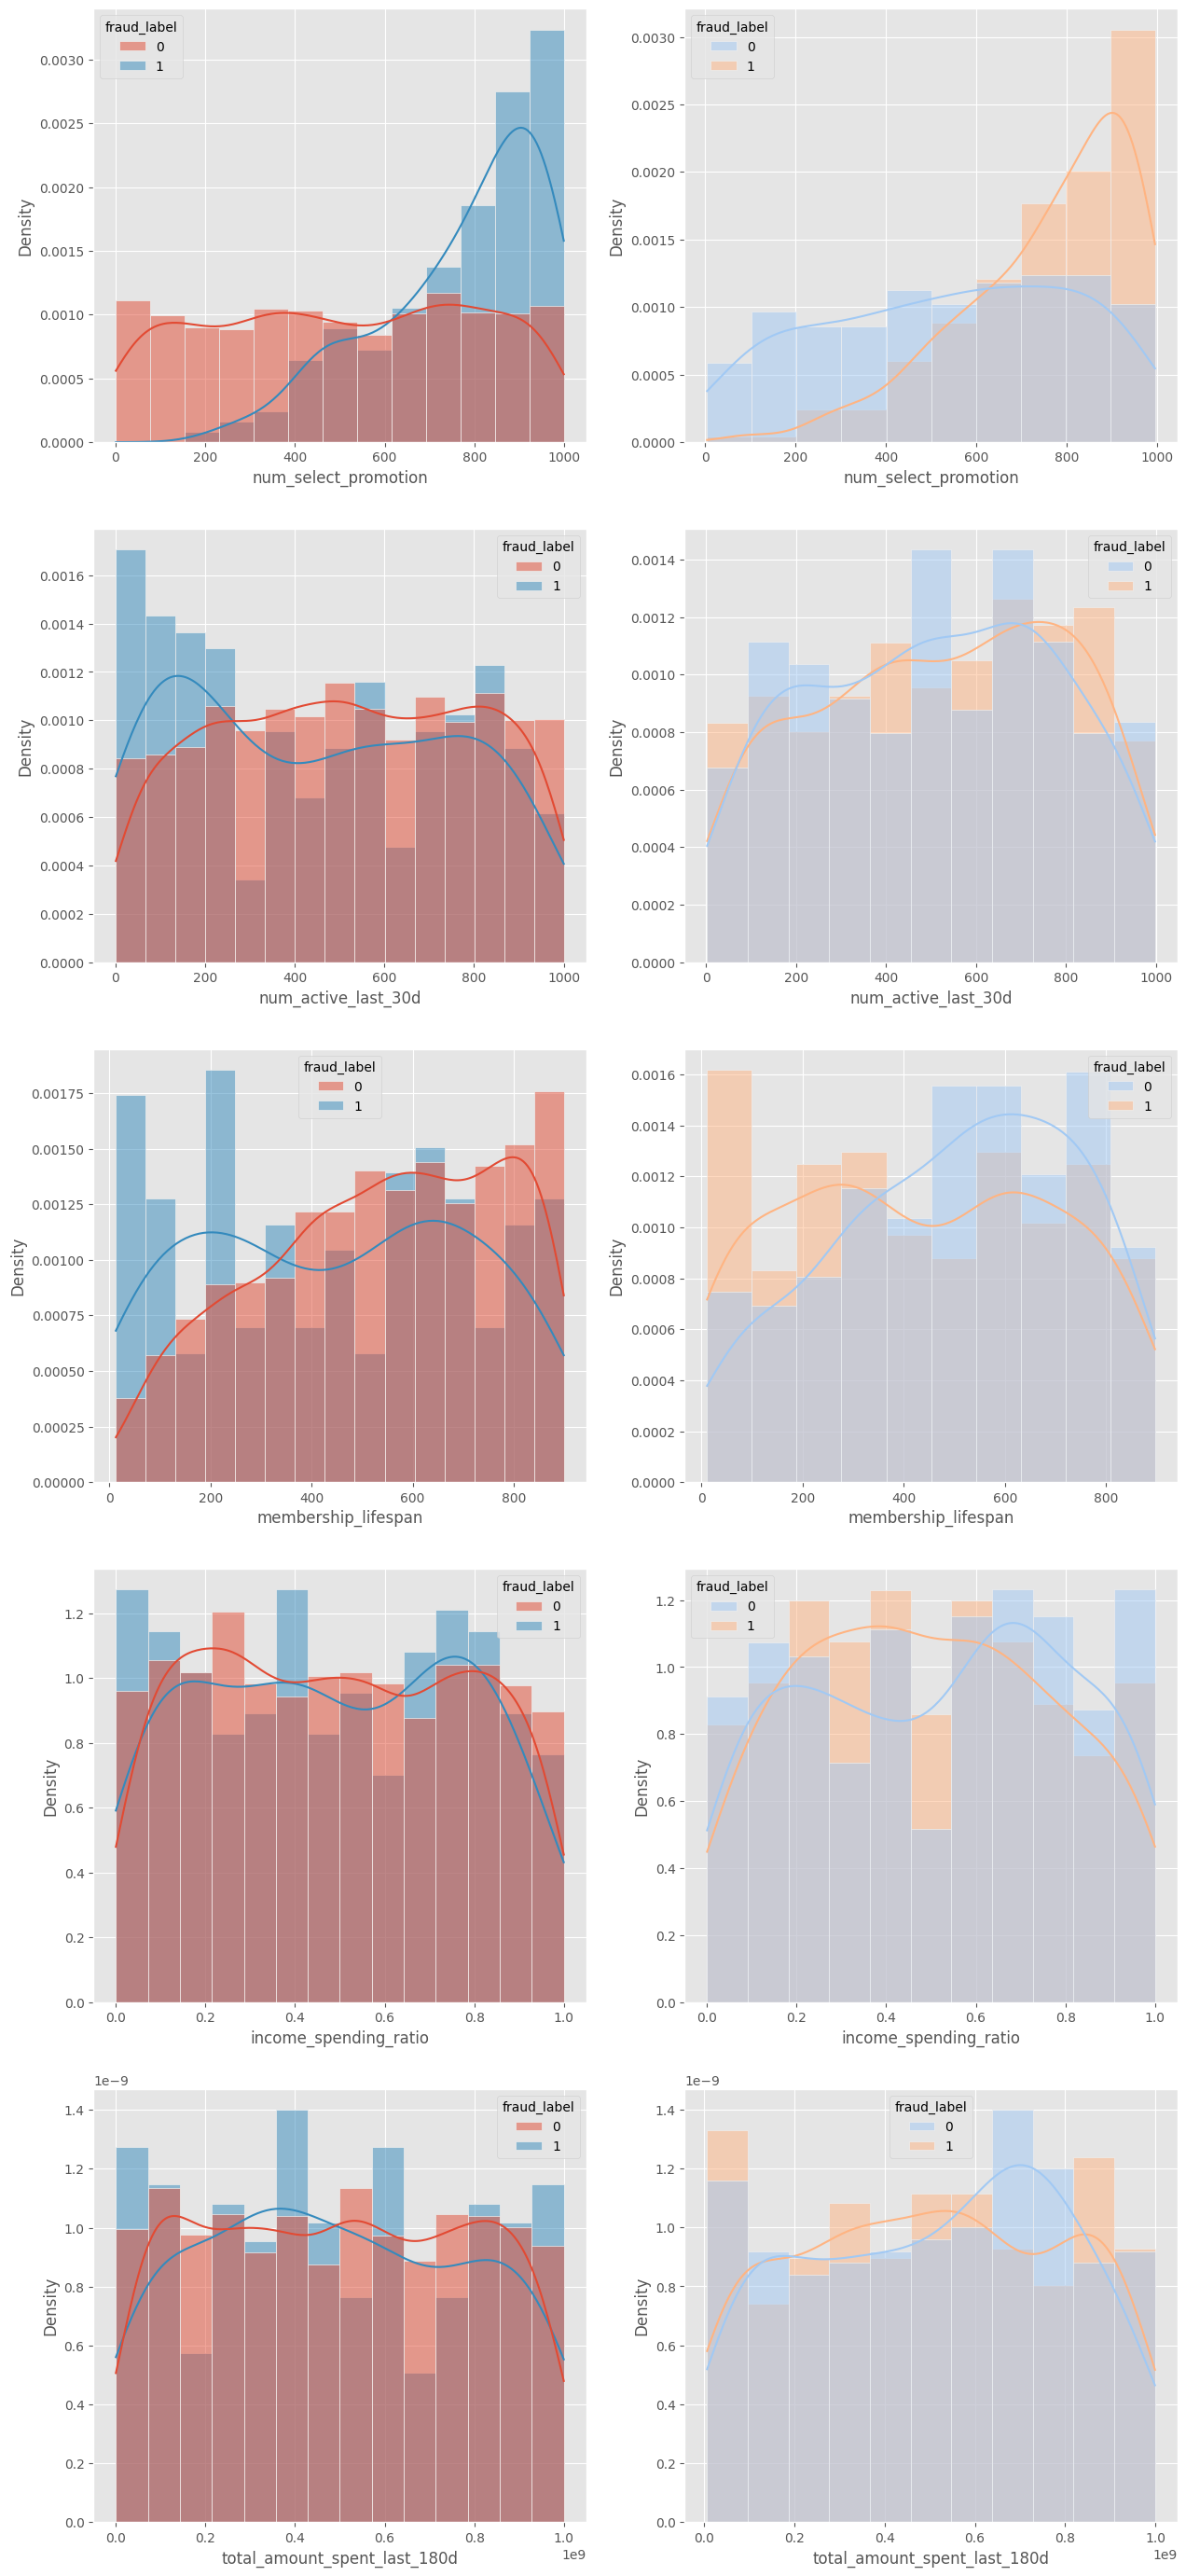

In [68]:
if len(aly_num_col) > 0:
    fig, axs = plt.subplots(len(aly_num_col),2, figsize=(15, len(aly_num_col) * 7))
    for idx, c in enumerate(aly_num_col):
        if len(aly_num_col) == 1:
            ax_left, ax_right = axs[0], axs[1]
        else:
            ax_left, ax_right = axs[idx][0], axs[idx][1]
        # Train
        sns.histplot(aly_train, x=c, hue="fraud_label",fill=True,ax=axs[idx][0],stat="density", common_norm=False, kde=True)
        # Test
        sns.histplot(aly_test, x=c, hue="fraud_label", fill=True,ax=axs[idx][1], palette='pastel',stat="density", common_norm=False, kde=True)
    plt.show()

Nhìn kỹ vào hình bên trái của num_select_promotion feature:

- Distribution của 0 và 1 (non-fraud & fraud) rất dễ để tách ra 2 lớp, 

- Bên test cũng tương tự vậy, đó là lý do tại sao model chọn feature này làm top vì khả năng phân tách cao

- Tương tư vậy với membership_lifespan bạn hãy tự nhận xét

**Phân tích mối tương quan 2 chiều giữa top 5 biến num**

**Train Dataset**

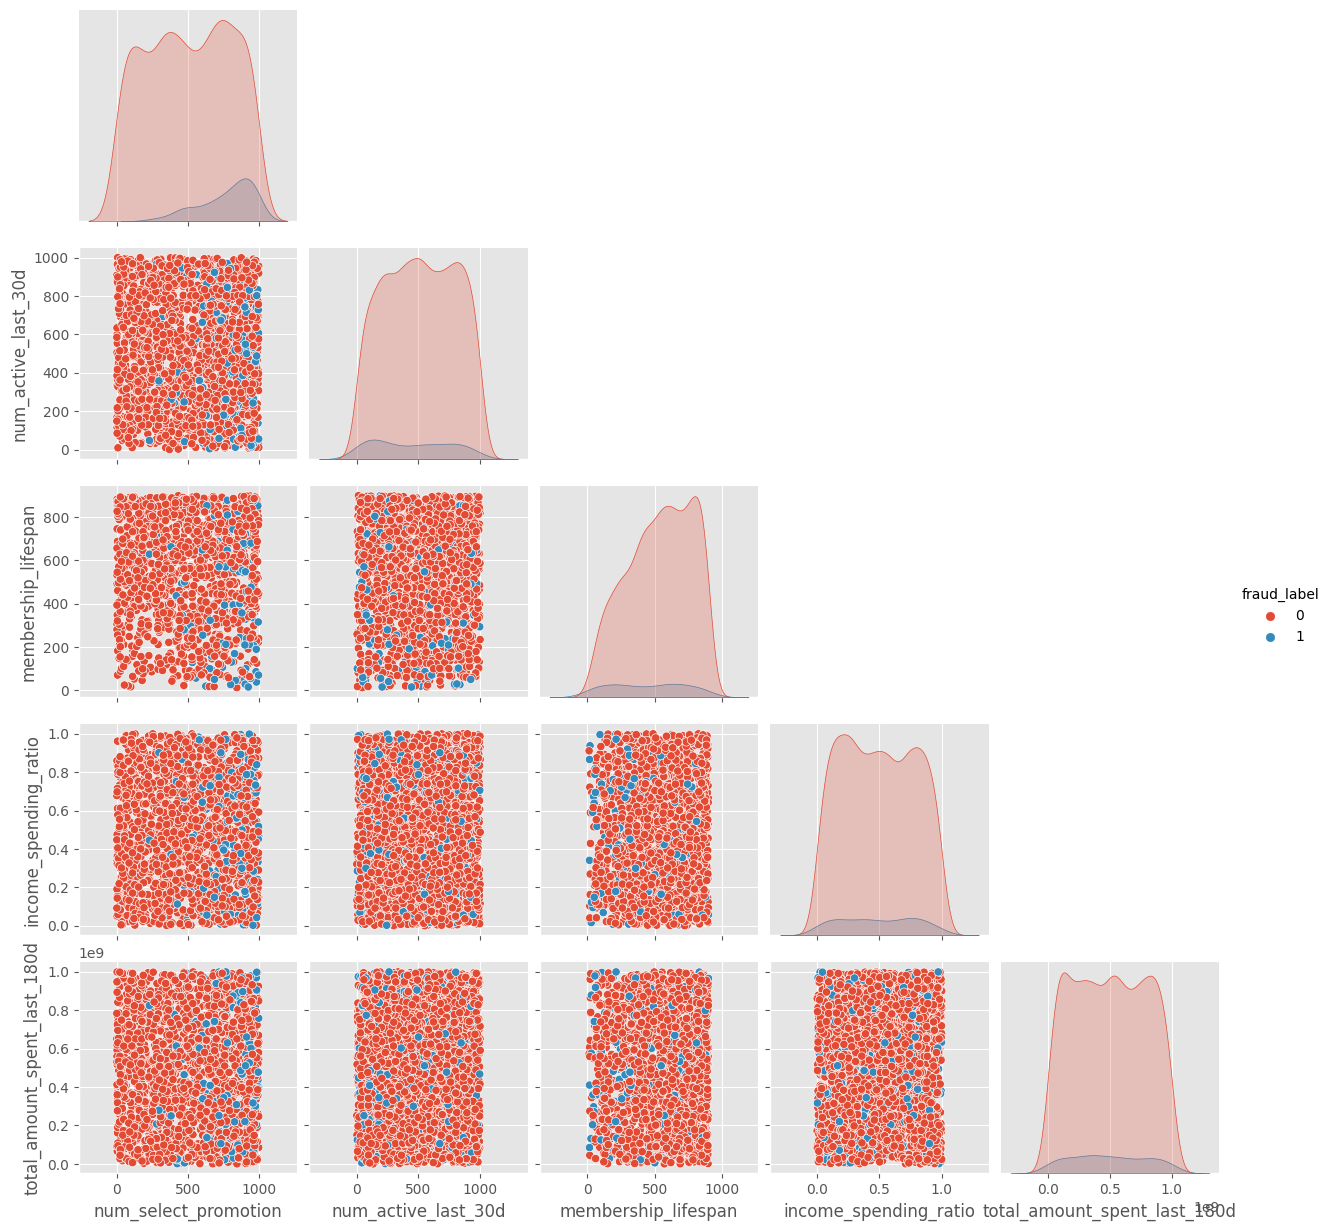

In [69]:
sns.pairplot(data=aly_train[aly_num_col[:k] + ['fraud_label']], hue="fraud_label", corner=True)

**Test Dataset**

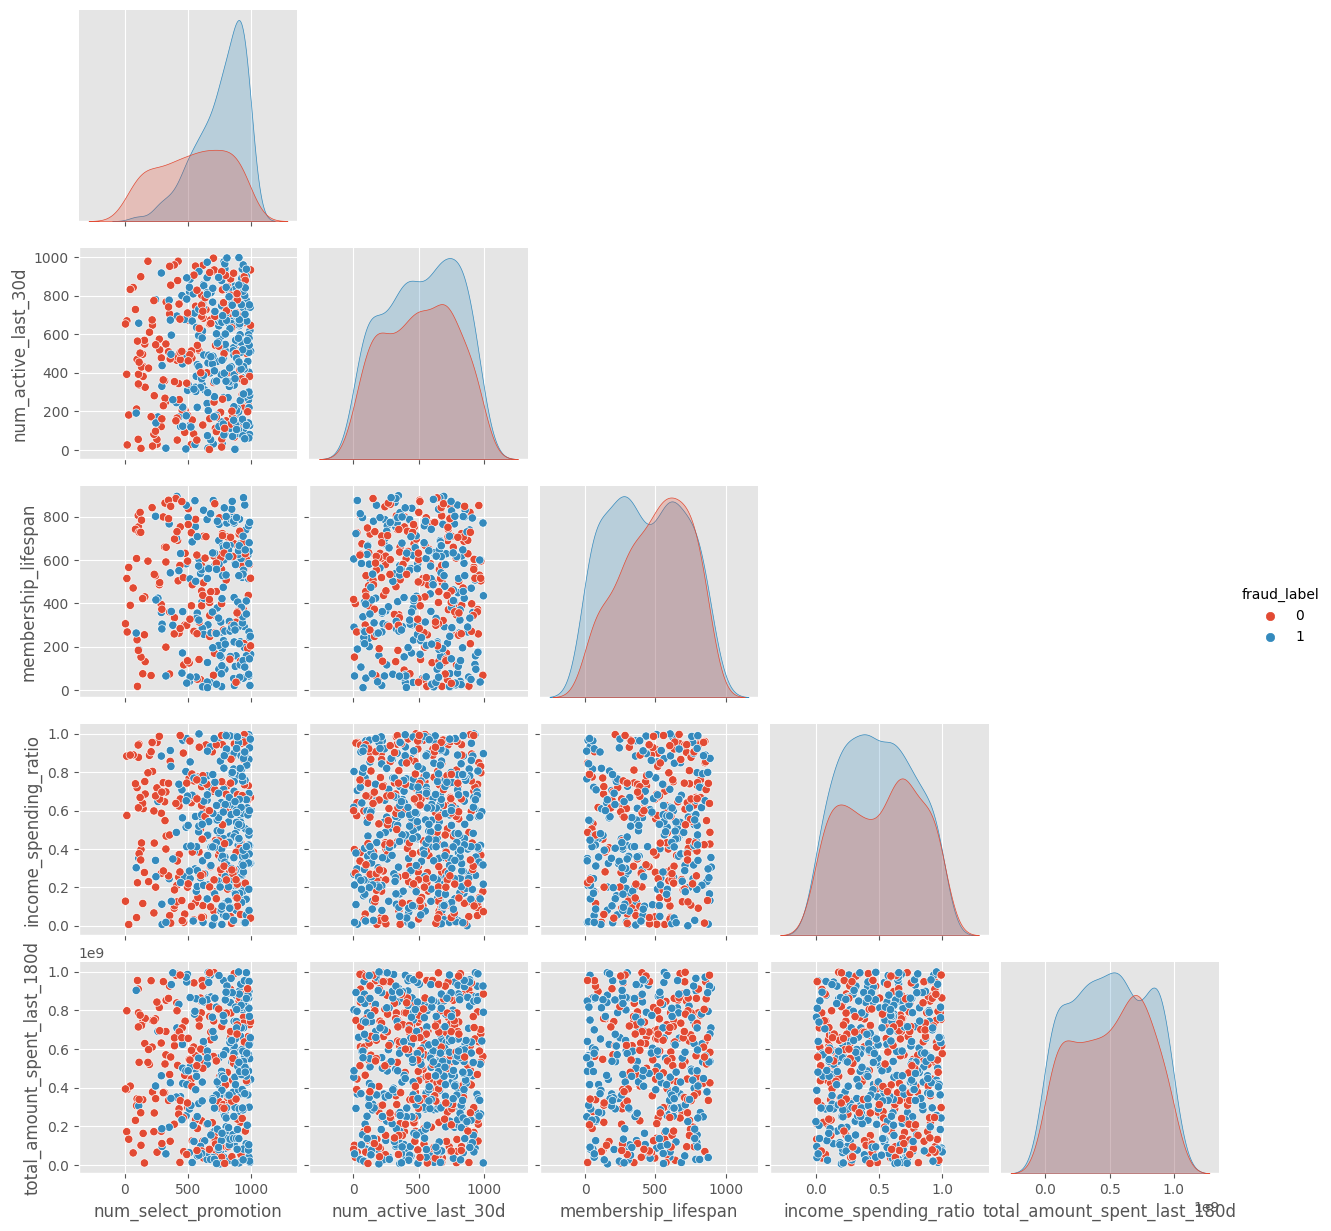

In [70]:
sns.pairplot(data=aly_test[aly_num_col[:k] + ['fraud_label']], hue="fraud_label", corner=True)

**Nhìn kỹ hơn về sự tương quan của top 1,2 num feature**

**Train Dataset**

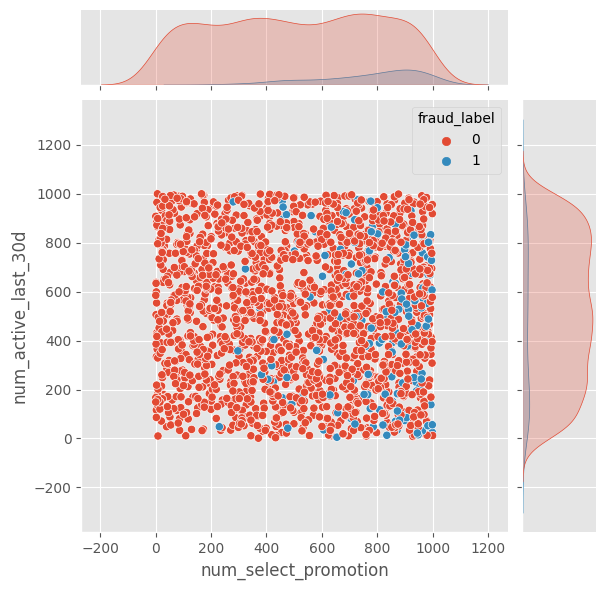

In [71]:
sns.jointplot(data=aly_train, x=aly_num_col[0], y=aly_num_col[1], hue="fraud_label")

**Test Dataset**

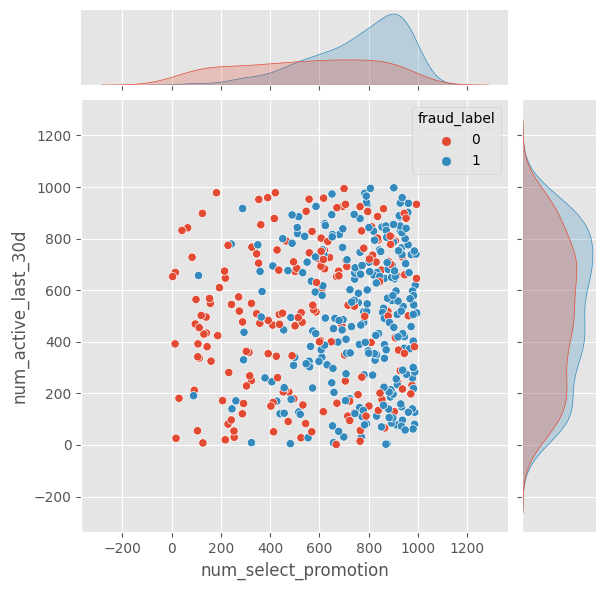

In [72]:
sns.jointplot(data=aly_test, x=aly_num_col[0], y=aly_num_col[1], hue="fraud_label")

Rõ ràng, ở bên test set ta thấy được pattern của fraud rõ ràng hơn

#### 5.2.3 Mixed Plot

Xem thử mối tương quan giữa top num và cat feature

<Axes: xlabel='num_select_promotion', ylabel='is_blacklist'>

/Users/quan/opt/miniconda3/envs/aicv/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 11.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


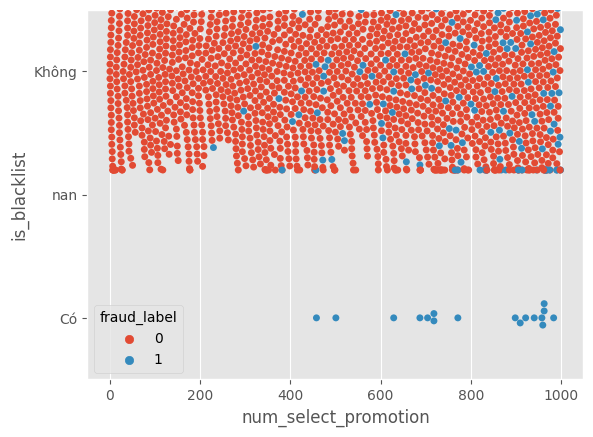

In [73]:
sns.swarmplot(data=aly_train, x=aly_num_col[0], y=aly_cat_col[0], hue="fraud_label")

<Axes: xlabel='num_select_promotion', ylabel='is_blacklist'>

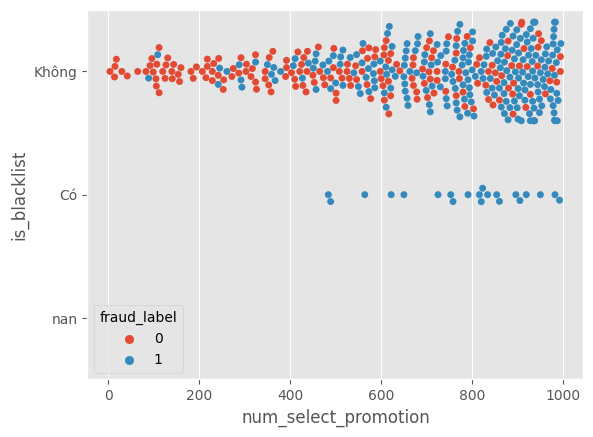

In [74]:
sns.swarmplot(data=aly_test, x=aly_num_col[0], y=aly_cat_col[0], hue="fraud_label")

Bạn hãy nhận xét 

## 6. Further Analysis

Phần này các bạn sẽ đọc và tìm hiểu thêm các technique khác


**Modeling technique**
- Hyper-parameters tuning
- Oversampling/Undersampling

**Feature Importance**
- SHAP value
- PDP plot

# C. Conclusion

Tổng kết lại, hôm nay chúng ta đã được đi qua sâu hơn vào kỹ thuật modeling nhiều hơn:

- Với numerical feature, bạn cần kiểm tra range của feature và impute cho null value
- Với category feature, bạn cần chuyển đổi thành dạng one-hot-vector
- Nắm rõ cách transform feature và cẩn thận với chúng
- Biết thêm được 1 số model khác như KNeighbors, Logistic Regression và XGBoost
- Hiểu business metrics và cách so sánh model performance
- Cách căn chỉnh threshold để tối ưu bài toán
- Cách chọn top k feature importance và phân tích ngược lại để tìm ra được hidden pattern